# Advisor Meeting 
### November 8, 2018
### Topics
* Noise Investigation (Boundary Crossing & Unobserved Detections)
* Large Fire Predictability
    * as a function of $k = 1,...,5$
    * as a function of day of fire
    * as a function of quantile used for def. of large fire

In [1]:
SRC_DIR = '../../src'
DATA_DIR = '/lv_scratch/scratch/graffc0/fire_prediction/data'
EXP_DIR = '/lv_scratch/scratch/graffc0/fire_prediction/experiments'

import numpy as np
import os
import sys
import datetime as dt
import pandas as pd

# Load project packages
src_path = os.path.abspath(os.path.join(SRC_DIR))
if src_path not in sys.path:
    sys.path.append(src_path)
    
from pipeline import train_pipeline
from helper import date_util as du

In [ ]:
# === Load data ===

# Load grid data
file_str = os.path.join(DATA_DIR, 'processed/grid/grid_ds_era_4_modis_alaska_2007-01-01_2016-12-31_interpolate_0roff_%dk.nc')
in_files = {k: file_str % k for k in range(1,6)}

start_date = dt.date(2007,1,1)
end_date = dt.date(2016,12,31)
forecast_horizon = 5

params = {'covariates': ('temperature', 'humidity', 'rain', 'wind'),
 'ignition_covariates_exclude': (),
 'memory_type': 'decay',
 'memory_covariates': ('temperature', 'humidity', 'rain', 'wind'),
 'memory_log_covariates': ('num_det',),
 'memory_length': 10,
 'decay_method': 'fixed',
 'decay_values': {'default': .05, 'num_det': .05, 'temperature': .25, 'humidity': .5, 'rain': .25},
 'active_check_days': 2,
 'log_correction_type': 'max',
 'log_correction_constant': 0.5,
 'log_covariates': ('num_det',),
 'forecast_method': 'separate',
 'fill_method': 'integrate_interp',
 'resolution': '4',
 'region': 'alaska',
 'forecast_horizon': forecast_horizon,
 'normalize_params': False,
 'rain_offset': 0,
 'use_era': True,
 'large_fire_split_percent': .9}

X_grid_dict_nw, y_grid_dict, _, _, _ = train_pipeline.setup_data(in_files, start_date, end_date, forecast_horizon, params)

# Load Modis
modis_df = pd.read_pickle(os.path.join(DATA_DIR, 'interim/modis/fire/fire_modis_alaska_2007-2016.pkl'))
modis_df = modis_df.assign(datetime_local=list(map(lambda x: du.utc_to_local_time(x[0], x[1], du.round_to_nearest_quarter_hour), zip(modis_df.datetime_utc, modis_df.lon))))

## Noise Investigation
* Fires Crossing Boundary
* Drop-offs in Detections (e.g. cloud cover)


### Boundary Crossing

In [116]:
import scipy.signal
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from evaluation.setup_data_structs import shift_in_time
from helper.geometry import get_default_bounding_box
import visualization.mapping as vmap

In [52]:
fire_det = y_grid_dict[1].values
dates = np.array(list(map(lambda x: pd.Timestamp(x).to_pydatetime().date(), X_grid_dict_nw[1][0].time.values)))

"""
Check that a cell:
1) Became active on day t
2) Had a neighbor active on day t-1
"""
def comp_neighbor_active(arr):
    result = np.zeros_like(became_active)
    kernel = np.array([[1,1,1], [1,0,1], [1,1,1]])
    for i in range(arr.shape[2]):
        result[:,:,i] = scipy.signal.correlate2d(arr[:,:,i], kernel, mode='same')
    return result

became_active = (shift_in_time(fire_det, dates, -1, np.zeros) == 0) & (fire_det > 0)
neighbor_active = comp_neighbor_active(shift_in_time(fire_det, dates, -1, np.zeros))

cross_boundary = became_active & neighbor_active

In [191]:
cross_boundary_masked = fire_det * cross_boundary
daily_cross_sizes = np.sum(cross_boundary_masked, axis=(0,1))

largest_days = np.argsort(daily_cross_sizes, axis=0)[::-1]

def date_ind_to_date(date_ind):
    year = date_ind // 110 + 2007
    date = dt.date(year, 5,14) + dt.timedelta(days=int(date_ind % 110))
    
    return date

largest_dates = list(map(date_ind_to_date, largest_days))

In [297]:
def plot_boundary_cross(largest_dates, largest_days, modis_df, condition, t, weather=None, offset=(0,0)):
    ALASKA_BB = get_default_bounding_box()
    YEAR_SEL = 2007
    
    t_date = largest_dates[t]+dt.timedelta(days=1)
    t_ind = largest_days[t]

    modis_df_days = np.array(list(map(lambda x: x.date(), np.array(modis_df.datetime_local))))

    fig = plt.figure()

    # Plot day t-1
    ax = fig.add_subplot(131)
    plt.title(t_date - dt.timedelta(days=1))
    mp = vmap.make_map(ALASKA_BB, (5,.5,5,.5))
    _ = mp.drawlsmask(land_color='w', ocean_color=(30./256,144./256,255./256,.3))

    lats, lons = ALASKA_BB.make_grid(inclusive_lon=True)
    cs = mp.pcolormesh(lons+offset[1], lats+offset[0], condition[:,:,t_ind], latlon=True, alpha=.8, cmap='binary')
    #cs = mp.pcolormesh(lons, lats, neighbor_active[:,:,t_ind], latlon=True, alpha=.8, cmap='binary')

    sel = modis_df_days == t_date-dt.timedelta(days=1)
    sel_df = modis_df[sel]
    _ = mp.scatter(list(sel_df.lon), list(sel_df.lat), 5, latlon=True, marker='o', color='r')


    # Plot day t
    ax = fig.add_subplot(132)
    plt.title(t_date)
    mp = vmap.make_map(ALASKA_BB, (5,.5,5,.5))
    _ = mp.drawlsmask(land_color='w', ocean_color=(30./256,144./256,255./256,.3))

    lats, lons = ALASKA_BB.make_grid(inclusive_lon=True)
    cs = mp.pcolormesh(lons+offset[1], lats+offset[0], condition[:,:,t_ind], latlon=True, alpha=.8, cmap='binary')
    #cs = mp.pcolormesh(lons, lats, neighbor_active[:,:,t_ind], latlon=True, alpha=.8, cmap='binary')

    sel = modis_df_days == t_date
    sel_df = modis_df[sel]
    _ = mp.scatter(list(sel_df.lon), list(sel_df.lat), 5, latlon=True, marker='o', color='r')

    # Plot day t+1
    ax = fig.add_subplot(133)
    plt.title(t_date + dt.timedelta(days=1))
    mp = vmap.make_map(ALASKA_BB, (5,.5,5,.5))
    _ = mp.drawlsmask(land_color='w', ocean_color=(30./256,144./256,255./256,.3))

    lats, lons = ALASKA_BB.make_grid(inclusive_lon=True)
    cs = mp.pcolormesh(lons+offset[1], lats+offset[0], condition[:,:,t_ind], latlon=True, alpha=.8, cmap='binary')
    #cs = mp.pcolormesh(lons, lats, neighbor_active[:,:,t_ind], latlon=True, alpha=.8, cmap='binary')

    sel = modis_df_days == t_date+dt.timedelta(days=1)
    sel_df = modis_df[sel]
    _ = mp.scatter(list(sel_df.lon), list(sel_df.lat), 5, latlon=True, marker='o', color='r')

    if weather is not None:
        fig = plt.figure()
        ax = fig.add_subplot(131)
        mp = vmap.make_map(ALASKA_BB, (5,.5,5,.5))
        _ = mp.drawlsmask(land_color='w', ocean_color=(30./256,144./256,255./256,.3))

        lats, lons = ALASKA_BB.make_grid(inclusive_lon=True)
        cs = mp.pcolormesh(lons+offset[1], lats+offset[0], weather[:,:,t_ind-1], latlon=True, alpha=.8, cmap='plasma')
        
        ax = fig.add_subplot(132)
        mp = vmap.make_map(ALASKA_BB, (5,.5,5,.5))
        _ = mp.drawlsmask(land_color='w', ocean_color=(30./256,144./256,255./256,.3))

        lats, lons = ALASKA_BB.make_grid(inclusive_lon=True)
        cs = mp.pcolormesh(lons+offset[1], lats+offset[0], weather[:,:,t_ind], latlon=True, alpha=.8, cmap='plasma')
        
        ax = fig.add_subplot(133)
        mp = vmap.make_map(ALASKA_BB, (5,.5,5,.5))
        _ = mp.drawlsmask(land_color='w', ocean_color=(30./256,144./256,255./256,.3))

        lats, lons = ALASKA_BB.make_grid(inclusive_lon=True)
        cs = mp.pcolormesh(lons+offset[1], lats+offset[0], weather[:,:,t_ind+1], latlon=True, alpha=.8, cmap='plasma')

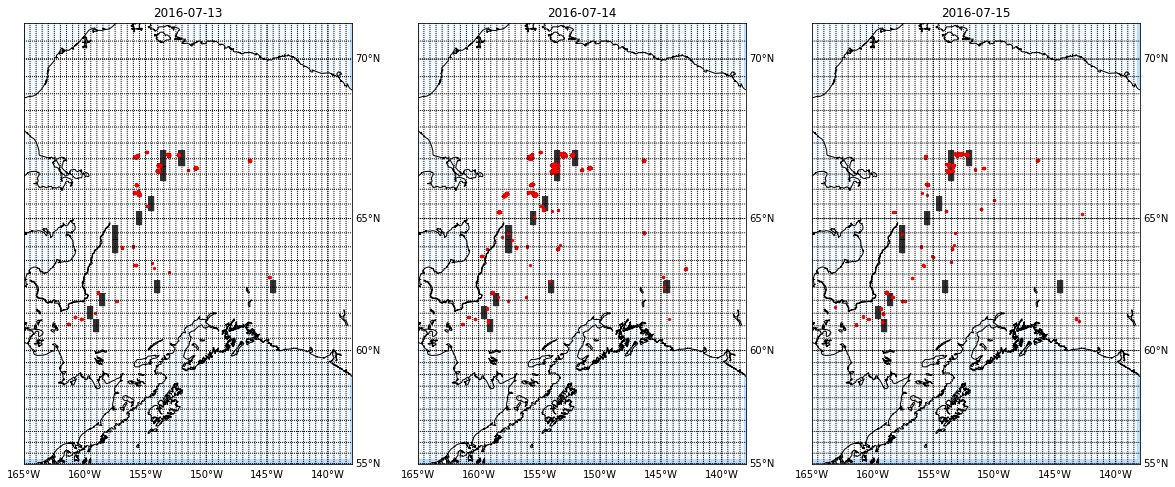

In [271]:
plt.rcParams['figure.figsize'] = [20,30]
plot_boundary_cross(largest_dates, largest_days, modis_df, cross_boundary, 0, offset=(.25, -.25))

In [1]:
active = fire_det > 0
plot_boundary_cross(largest_dates, largest_days, modis_df, active, 1, offset=(.25, -.25))

NameError: name 'fire_det' is not defined

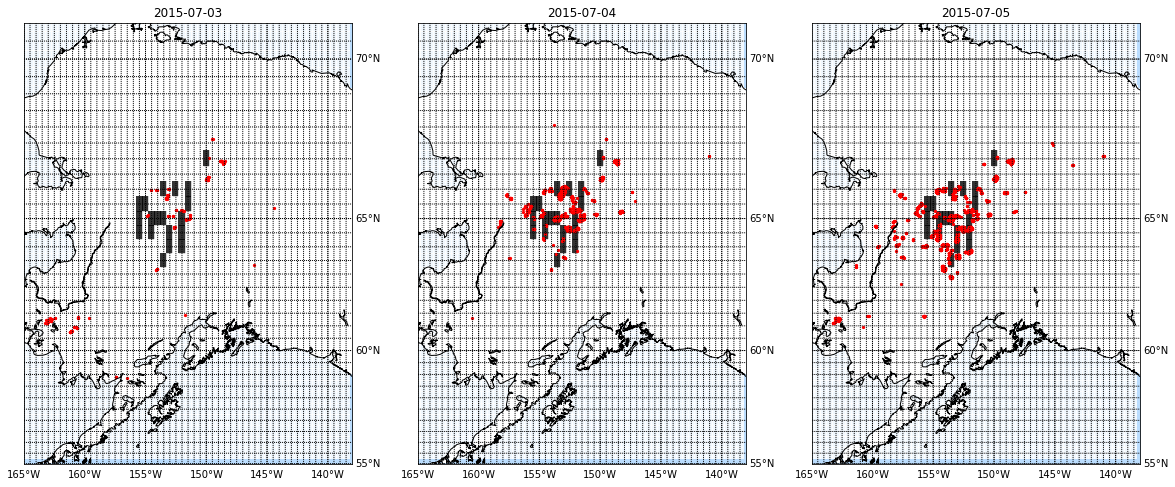

In [277]:
plt.rcParams['figure.figsize'] = [20,30]
plot_boundary_cross(largest_dates, largest_days, modis_df, cross_boundary, 1, offset=(.25, -.25))

* Not all "detected" boundary crossings are legitimate
* Appears to be a slight mismatch b/w grid cells and scatter points
* (Internal) off-by-one on date/day_ind

Num Days: 1100, Num Non-Zero: 267 (24.27%)


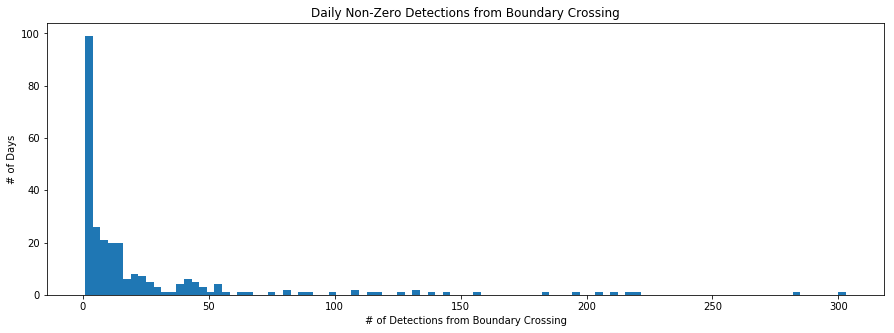

In [218]:
plt.rcParams['figure.figsize'] = [15,5]

plt.title('Daily Non-Zero Detections from Boundary Crossing')
plt.ylabel('# of Days')
plt.xlabel('# of Detections from Boundary Crossing')
_ = plt.hist(daily_cross_sizes[daily_cross_sizes>0], bins=100)

num_days = len(daily_cross_sizes)
num_non_zero = len(daily_cross_sizes[daily_cross_sizes>0])
print('Num Days: %d, Num Non-Zero: %d (%.2f%%)' % (num_days, num_non_zero, num_non_zero/num_days*100))

### Cloud Cover

In [222]:
"""
Check that a cell:
1) Was active on day t-1
2) Was not active on day t
3) Was active on day t+1
"""

was_active = shift_in_time(fire_det, dates, -1, np.zeros) > 0
inactive = fire_det == 0
will_be_active = shift_in_time(fire_det, dates, +1, np.zeros) > 0

cloud_cover = was_active & inactive & will_be_active

In [229]:
def comp_cloud_magnitude(arr):
    result = np.zeros_like(arr)
    for i in range(1,arr.shape[2]-1):
        result[:,:,i] = arr[:,:,i-1] + arr[:,:,i+1]
    return result

cloud_magnitude_masked = comp_cloud_magnitude(fire_det) * cloud_cover

daily_cloud_magnitude = np.sum(cloud_magnitude_masked, axis=(0,1))

largest_days_cloud = np.argsort(daily_cloud_magnitude, axis=0)[::-1]
largest_dates_cloud = list(map(date_ind_to_date, largest_days_cloud))

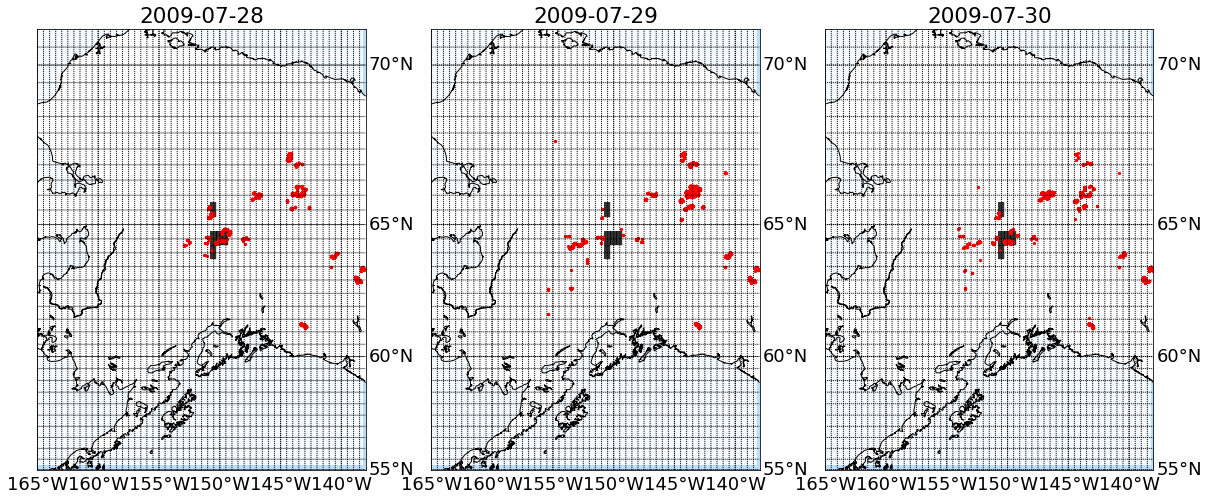

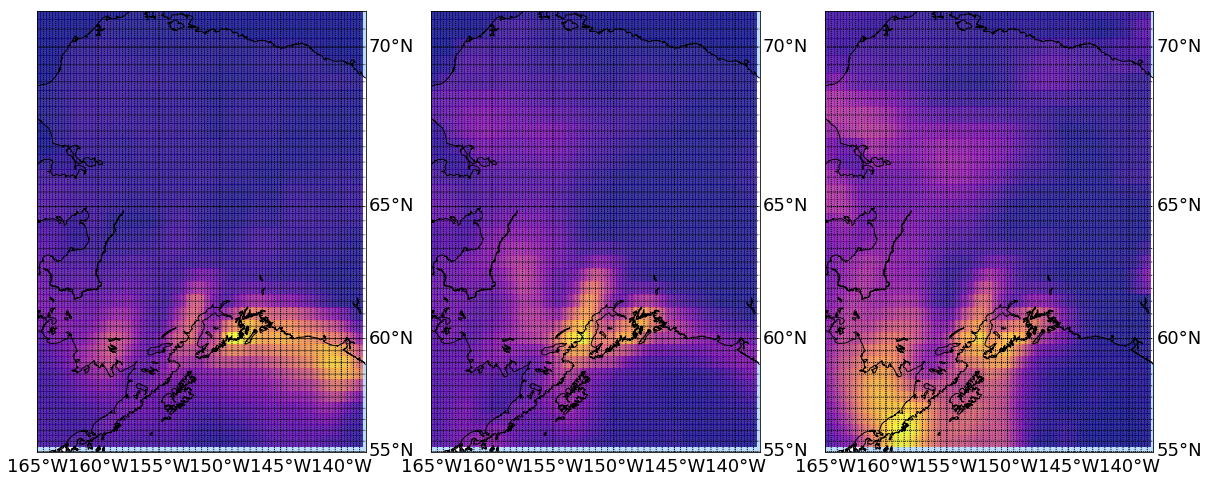

In [382]:
plt.rcParams['figure.figsize'] = [20,30]
plot_boundary_cross(largest_dates_cloud, largest_days_cloud, modis_df, cloud_cover, 0, offset=(.25, -.25),
                    weather=X_grid_dict_nw[1][0].rain_1.values)

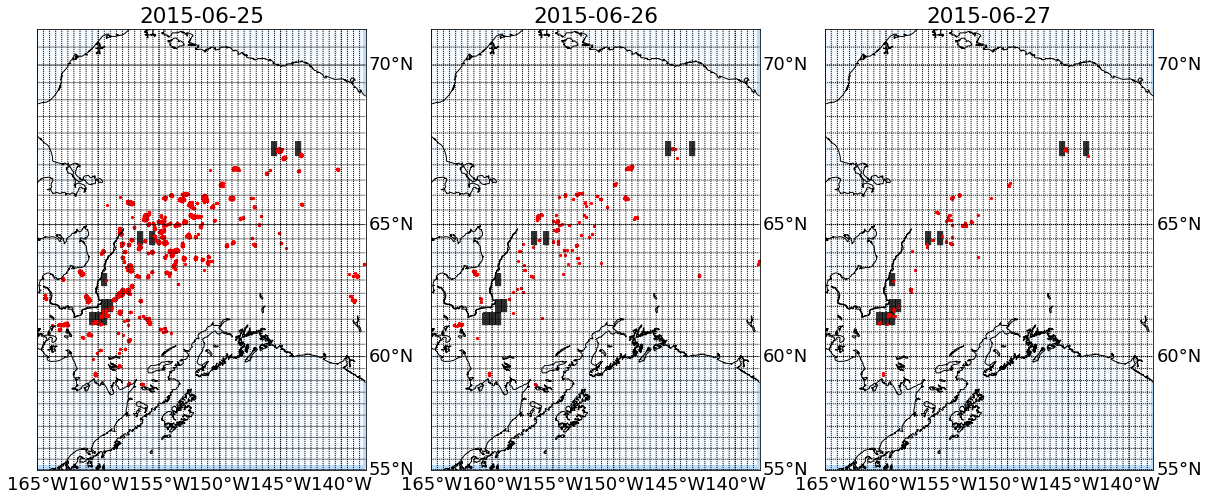

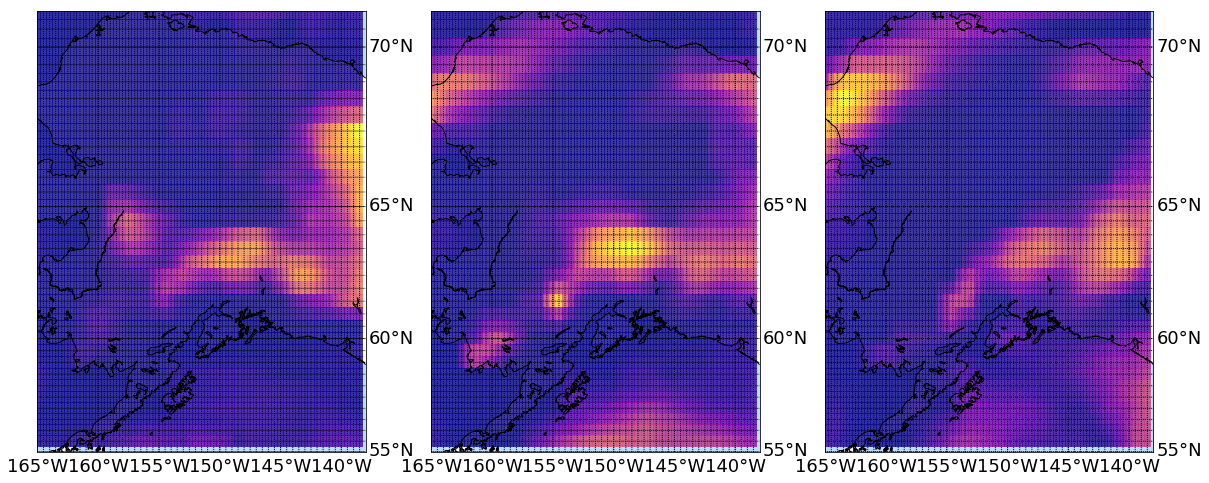

In [383]:
plt.rcParams['figure.figsize'] = [20,30]
plot_boundary_cross(largest_dates_cloud, largest_days_cloud, modis_df, cloud_cover, 1, offset=(.25, -.25),
                    weather=X_grid_dict_nw[1][0].rain_1.values)

Num Days: 1100, Num Non-Zero: 200 (18.18%)


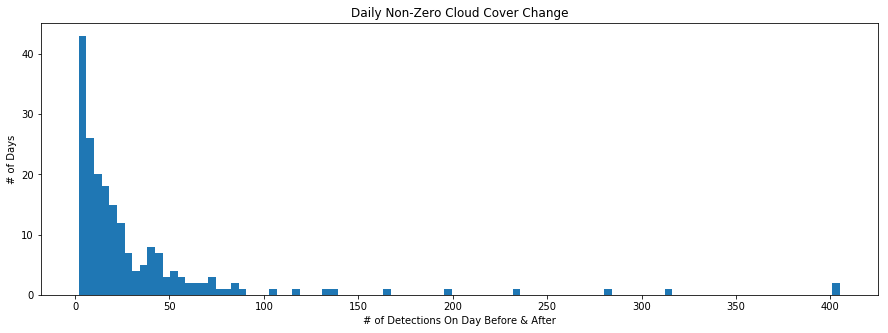

In [240]:
plt.rcParams['figure.figsize'] = [15,5]

plt.title('Daily Non-Zero Cloud Cover Change')
plt.ylabel('# of Days')
plt.xlabel('# of Detections On Day Before & After')
_ = plt.hist(daily_cloud_magnitude[daily_cloud_magnitude>0], bins=100)

num_days = len(daily_cross_sizes)
num_non_zero = len(daily_cloud_magnitude[daily_cloud_magnitude>0])
print('Num Days: %d, Num Non-Zero: %d (%.2f%%)' % (num_days, num_non_zero, num_non_zero/num_days*100))

In [304]:
np.sum(fire_det[:,:,109::110])

20.0

## Large Fire Predictability
* as a function of $k = 1,...,5$
* as a function of day of fire
* as a function of quantile used for def. of large fire

In [316]:
import pickle
from matplotlib import gridspec

In [317]:
def plot_active_ignition(results_dict, measurements, scale=False, markers=None, sample='test', label=None, baseline=None, min_y=None, y_labels=None, col_len=2):
    num_plots = len(measurements)
    gs = gridspec.GridSpec(int(np.ceil(num_plots/col_len)), 4)
    fig = plt.figure()
    
    ax = None
    for i, (name,meas,share,use_baseline) in enumerate(measurements):            
        row = i//col_len
        col = int(np.remainder(i,col_len))
        col_ind1 = col*col_len
        col_ind2 = (col+1)*col_len
    
        if (i == len(measurements)-1) and (np.remainder(i,2)==0):
            col_ind1 = col*col_len + 1
            col_ind2 = (col+1)*col_len + 1
        if scale and share:
            ax = fig.add_subplot(gs[row, col_ind1:col_ind2], sharey=ax)
        else:
            ax = fig.add_subplot(gs[row, col_ind1:col_ind2])
        plt.xlabel('Days')
        plt.title(name)
        if y_labels:
            plt.ylabel(y_labels[i])
        elif np.remainder(i,col_len)==0:
            if label:
                plt.ylabel(label)
            elif scale:
                plt.ylabel('MSE')
            else:
                plt.ylabel('RMSE')
        for j,(k,v) in enumerate(results_dict.items()):
            marker = '-'
            if markers is not None:
                marker += markers[j]
                
            results = v[sample][meas][1][1:]  
            if scale:                
                try:
                    scale_factor = v[sample][meas][2] 
                except:
                    scale_factor = [1] * len(results)
                #results = np.sqrt(np.array(results)**2 * scale[name])
                results = np.array(results)**2 * np.array(scale_factor)
                
            if baseline is not None and use_baseline:
                if k == baseline:
                    continue
                baseline_results = results_dict[baseline][sample][meas][1][1:]  
                if scale:                
                    try:
                        scale_factor = results_dict[baseline][sample][meas][2] 
                    except:
                        scale_factor = [1] * len(baseline_results)
                    baseline_results = np.array(baseline_results)**2 * np.array(scale_factor)
                
                results = (baseline_results - results) / baseline_results * 100
                #results = 100 - results
                #plt.ylabel('100 - MSE SS %')
                
            x = range(1,len(results)+1)
            plt.plot(x, results, marker, label=k)
            plt.xticks(x)
            
        if min_y is not None:
            y_min,y_max = plt.ylim()
            plt.ylim(min_y, y_max)
            
            
        if (i==(col_len-1)) or (len(measurements)==1):
            _ = plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    
    gs.tight_layout(fig)
    
    

In [312]:
%%capture
# Large-split Model (.9)
with open(os.path.join(EXP_DIR, '17875152189947403152619969410148376857.pkl'), 'rb') as fin:
    large_split_90 = pickle.load(fin)

In [328]:
%%capture
# Large-split Model (.9)
with open(os.path.join(EXP_DIR, '218751488024075761354577216499850980626.pkl'), 'rb') as fin:
    large_split_80 = pickle.load(fin)

In [342]:
%%capture
# Large-split Model (.9)
with open(os.path.join(EXP_DIR, '262568614057467251628366989370778743067.pkl'), 'rb') as fin:
    large_split_50 = pickle.load(fin)

In [373]:
%%capture
with open(os.path.join(EXP_DIR, '202399934703193354839292243207122060736.pkl'), 'rb') as fin:
    persistence = pickle.load(fin)

In [370]:
%%capture
# Large-split Model (.9)
with open(os.path.join(EXP_DIR, '220181091031303148922946087817030752793.pkl'), 'rb') as fin:
    poisson = pickle.load(fin)

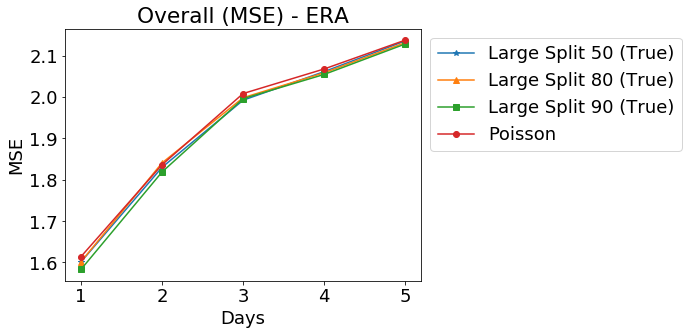

In [375]:
plt.rcParams['figure.figsize'] = [32,5]

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

results_dict = {'Large Split 50 (True)': large_split_50['summary_results'],
                'Large Split 80 (True)': large_split_80['summary_results'],
                'Large Split 90 (True)': large_split_90['summary_results'],
                #'Persistence': persistence['summary_results'],
                'Poisson': poisson['summary_results']
               }
measurements = [(r'Overall (MSE) - ERA','root_mean_squared_error', False, False),]

alpha = 0.0049727
plot_active_ignition(results_dict, measurements, baseline='Persistence', scale=True, markers=['*', '^', 's', 'o', 'x', 'd', 'v', 'p', 'P', '1'], y_labels = ['MSE', 'MSE SS %'], col_len=1)

In [433]:
# Load data for running models
file_str = os.path.join(DATA_DIR, 'processed/grid/grid_ds_era_4_modis_alaska_2007-01-01_2016-12-31_interpolate_0roff_%dk.nc')
in_files = {k: file_str % k for k in range(1,6)}

start_date = dt.date(2007,1,1)
end_date = dt.date(2016,12,31)
forecast_horizon = 5

X_grid_dict_nw_models_90, y_grid_dict_models, _, _, _ = train_pipeline.setup_data(in_files, start_date, end_date, forecast_horizon, large_split_90['params'])
X_grid_dict_df_nw_models_90 = {k: v[0].to_dataframe() for (k,v) in X_grid_dict_nw_models_90.items()}

In [434]:
pred_90_dict = {k: large_split_90['models'][k-1][0].afm.model.mixture_model.predict(X_grid_dict_df_nw_models_90[k][X_grid_dict_df_nw_models_90[k].active]) for k in [1,2,3,4,5]}

In [437]:
# Load data for running models
file_str = os.path.join(DATA_DIR, 'processed/grid/grid_ds_era_4_modis_alaska_2007-01-01_2016-12-31_interpolate_0roff_%dk.nc')
in_files = {k: file_str % k for k in range(1,6)}

start_date = dt.date(2007,1,1)
end_date = dt.date(2016,12,31)
forecast_horizon = 5

X_grid_dict_nw_models_80, y_grid_dict_models, _, _, _ = train_pipeline.setup_data(in_files, start_date, end_date, forecast_horizon, large_split_80['params'])
X_grid_dict_df_nw_models_80 = {k: v[0].to_dataframe() for (k,v) in X_grid_dict_nw_models_80.items()}

In [438]:
pred_80_dict = {k: large_split_80['models'][k-1][0].afm.model.mixture_model.predict(X_grid_dict_df_nw_models_80[k][X_grid_dict_df_nw_models_80[k].active]) for k in [1,2,3,4,5]}

In [439]:
# Load data for running models
file_str = os.path.join(DATA_DIR, 'processed/grid/grid_ds_era_4_modis_alaska_2007-01-01_2016-12-31_interpolate_0roff_%dk.nc')
in_files = {k: file_str % k for k in range(1,6)}

start_date = dt.date(2007,1,1)
end_date = dt.date(2016,12,31)
forecast_horizon = 5

X_grid_dict_nw_models_50, y_grid_dict_models, _, _, _ = train_pipeline.setup_data(in_files, start_date, end_date, forecast_horizon, large_split_50['params'])
X_grid_dict_df_nw_models_50 = {k: v[0].to_dataframe() for (k,v) in X_grid_dict_nw_models_50.items()}

In [440]:
pred_50_dict = {k: large_split_50['models'][k-1][0].afm.model.mixture_model.predict(X_grid_dict_df_nw_models_50[k][X_grid_dict_df_nw_models_50[k].active]) for k in [1,2,3,4,5]}

### as a function of $k = 1,...,5$

0.07413376309427902
0.07342868654311031
0.07151490733279643
0.06819097502014503
0.0639605157131344


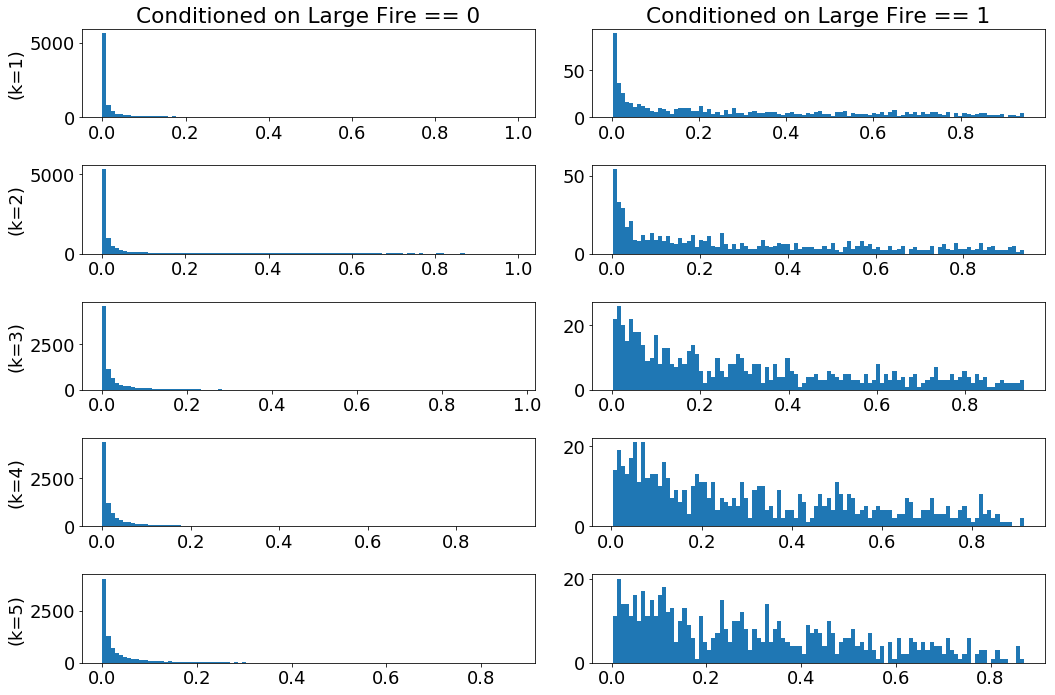

In [419]:
plt.rcParams['figure.figsize'] = [15,10]

fig = plt.figure()
for i in [1,2,3,4,5]:
    target = X_grid_dict_df_nw_models_90[k][X_grid_dict_df_nw_models_90[k].active].large_fire
    ax = fig.add_subplot(5,2,i*2-1)
    _ = plt.hist(pred_90_dict[i][target==0],bins=100)
    plt.ylabel('(k=%d)'% i)
    if i == 1:
        plt.title('Conditioned on Large Fire == 0')
    ax = fig.add_subplot(5,2,i*2)
    _ = plt.hist(pred_90_dict[i][target==1],bins=100)
    if i == 1:
        plt.title('Conditioned on Large Fire == 1')
        
    print(np.mean(pred_90_dict[i]))
plt.tight_layout()

0.14585012087026647
0.1419218372280418
0.13094278807413406
0.11684125705076535
0.10253827558420615


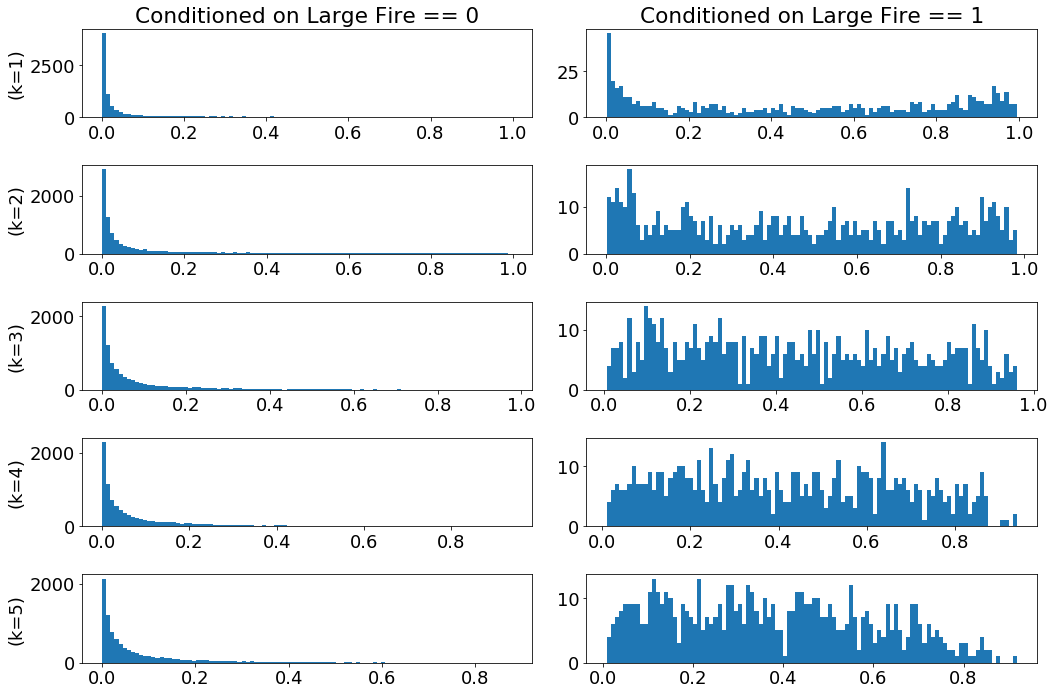

In [442]:
plt.rcParams['figure.figsize'] = [15,10]

fig = plt.figure()
for i in [1,2,3,4,5]:
    target = X_grid_dict_df_nw_models_80[k][X_grid_dict_df_nw_models_80[k].active].large_fire
    ax = fig.add_subplot(5,2,i*2-1)
    _ = plt.hist(pred_80_dict[i][target==0],bins=100)
    plt.ylabel('(k=%d)'% i)
    if i == 1:
        plt.title('Conditioned on Large Fire == 0')
    ax = fig.add_subplot(5,2,i*2)
    _ = plt.hist(pred_80_dict[i][target==1],bins=100)
    if i == 1:
        plt.title('Conditioned on Large Fire == 1')
        
    print(np.mean(pred_80_dict[i]))
plt.tight_layout()

0.34840854149879164
0.29361402095084843
0.24022965350523762
0.20255842062852486
0.17717566478646332


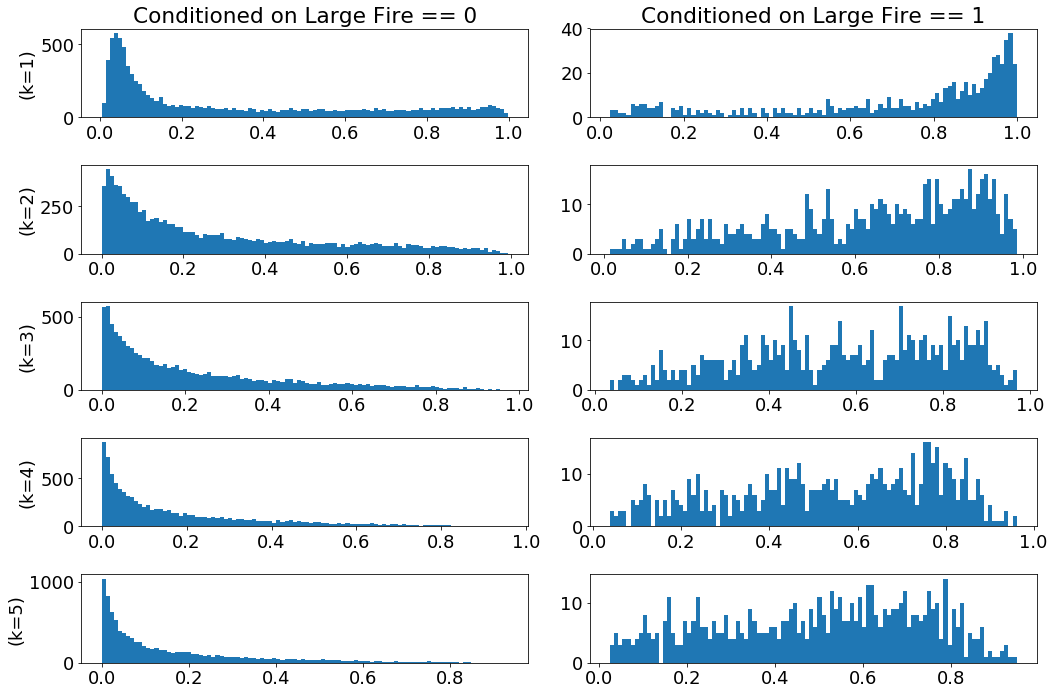

In [441]:
plt.rcParams['figure.figsize'] = [15,10]

fig = plt.figure()
for i in [1,2,3,4,5]:
    target = X_grid_dict_df_nw_models_50[k][X_grid_dict_df_nw_models_50[k].active].large_fire
    ax = fig.add_subplot(5,2,i*2-1)
    _ = plt.hist(pred_50_dict[i][target==0],bins=100)
    plt.ylabel('(k=%d)'% i)
    if i == 1:
        plt.title('Conditioned on Large Fire == 0')
    ax = fig.add_subplot(5,2,i*2)
    _ = plt.hist(pred_50_dict[i][target==1],bins=100)
    if i == 1:
        plt.title('Conditioned on Large Fire == 1')
        
    print(np.mean(pred_50_dict[i]))
plt.tight_layout()

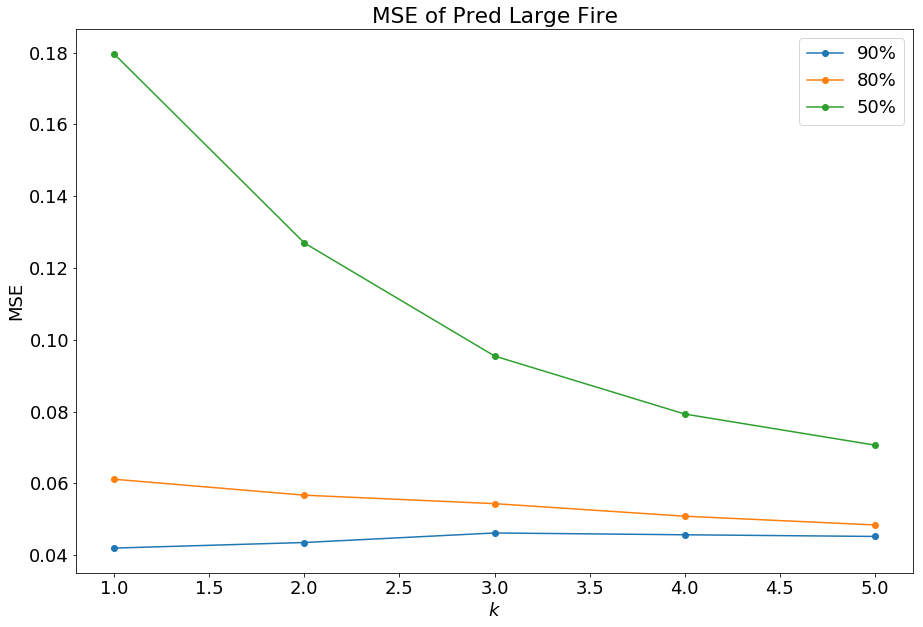

In [445]:
mse_90 = []
mse_80 = []
mse_50 = []

for k in [1,2,3,4,5]:
    target = X_grid_dict_df_nw_models_90[k][X_grid_dict_df_nw_models_90[k].active].large_fire
    mse_90.append(np.mean((target - pred_90_dict[k])**2))
    
    target = X_grid_dict_df_nw_models_80[k][X_grid_dict_df_nw_models_80[k].active].large_fire
    mse_80.append(np.mean((target - pred_80_dict[k])**2))
    
    target = X_grid_dict_df_nw_models_50[k][X_grid_dict_df_nw_models_50[k].active].large_fire
    mse_50.append(np.mean((target - pred_50_dict[k])**2))
    
plt.title('MSE of Pred Large Fire')
plt.ylabel('MSE')
plt.xlabel('$k$')
_ = plt.plot([1,2,3,4,5],mse_90, 'o-', label='90%')
_ = plt.plot([1,2,3,4,5],mse_80, 'o-', label='80%')
_ = plt.plot([1,2,3,4,5],mse_50, 'o-', label='50%')

plt.legend()

In [ ]:
# 90 = 145, 80 = 69, 50 = 13

### as a function of day of fire

In [456]:
def add_day_of_fire(X_grid_dict):
    for X_ds in X_grid_dict.values():
        print(X_ds[0].num_det.values.shape)

In [458]:
add_day_of_fire(X_grid_dict_nw_models_80)

(33, 55, 1100)
(33, 55, 1100)
(33, 55, 1100)
(33, 55, 1100)
(33, 55, 1100)


### Ours vs. EU Model

In [512]:
p_vpd = {'train': {'root_mean_squared_error': (['Avg.', 1, 2, 3, 4, 5], [1.6791562936206237, 1.669404890631818, 1.6496482533356422, 1.6868939110938381, 1.6707649343079949, 1.7190694787338257]), 'mean_absolute_error': (['Avg.', 1, 2, 3, 4, 5], [0.05929449478643041, 0.05263587336271551, 0.057729812529017578, 0.060502886044449644, 0.061486514379056972, 0.064117387616912352])}, 'test': {'root_mean_squared_error': (['Avg.', 1, 2, 3, 4, 5], [1.6791562936206244, 1.6694048906318188, 1.6496482533356431, 1.6868939110938372, 1.6707649343079947, 1.7190694787338272]), 'mean_absolute_error': (['Avg.', 1, 2, 3, 4, 5], [0.059294494786430382, 0.052635873362715489, 0.057729812529017654, 0.060502886044449644, 0.061486514379056931, 0.064117387616912241]), 'root_mean_squared_error_active': (['Avg.', 1, 2, 3, 4, 5], [21.13526323451579, 23.222655289752552, 21.679980590193733, 20.89317177685577, 19.876005230779263, 20.004503284997622], [0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763]), 'mean_absolute_error_active': (['Avg.', 1, 2, 3, 4, 5], [8.645030100836852, 9.4347825512350383, 9.1163951162554131, 8.5598319890958656, 8.0627342826135315, 8.0514065649844149], [0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763]), 'root_mean_squared_error_ignition': (['Avg.', 1, 2, 3, 4, 5], [0.7333040757127034, 0.32511717534932794, 0.62127407772608678, 0.82357571081962411, 0.91164382752251272, 0.98490958714596566], [0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944]), 'mean_absolute_error_ignition': (['Avg.', 1, 2, 3, 4, 5], [0.016386821116979401, 0.0057480926943498647, 0.012458647358364057, 0.01802703350293873, 0.021499849992852007, 0.024200482036392339], [0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944]), 'root_mean_squared_error_active_target': (['Avg.', 1, 2, 3, 4, 5], [32.834497802155923, 32.255860033129579, 31.180347024677712, 33.31559425724155, 33.165997108762888, 34.254690586967882], [0.002378662659654395, 0.0019273729025795141, 0.0016083145504633108, 0.0014034560480841473, 0.0012787377911344855]), 'mean_absolute_error_active_target': (['Avg.', 1, 2, 3, 4, 5], [17.700560325113777, 16.358095481060523, 17.162183636204524, 18.086238809205454, 18.20629887973001, 18.68998481936837], [0.002378662659654395, 0.0019273729025795141, 0.0016083145504633108, 0.0014034560480841473, 0.0012787377911344855]), 'root_mean_squared_error_ignition_target': (['Avg.', 1, 2, 3, 4, 5], [16.687416759396218, 9.4394909721468974, 15.332960010388062, 18.574313490380323, 19.561423297126538, 20.528896026939272], [0.0011800651139494114, 0.0016333583771600301, 0.0019559228650137743, 0.0021607813673929378, 0.0022895066366140746]), 'mean_absolute_error_ignition_target': (['Avg.', 1, 2, 3, 4, 5], [8.3907605840069355, 4.8382852292020377, 7.5786568537258514, 9.1572343149807942, 9.8843300880853029, 10.495296434040691], [0.0011800651139494114, 0.0016333583771600301, 0.0019559228650137743, 0.0021607813673929378, 0.0022895066366140746]), 'root_mean_squared_error_zero_zero_target': (['Avg.', 1, 2, 3, 4, 5], [0.010710623272590144, 0.0052167786071629805, 0.0077784884776003534, 0.010068693937956459, 0.011884992884243597, 0.018604162455987332], [0.99384723265715003, 0.99339393939393938, 0.99307137490608566, 0.99286651640370649, 0.99273779113448535]), 'mean_absolute_error_zero_zero_target': (['Avg.', 1, 2, 3, 4, 5], [2.834781784485013e-05, 1.0079547791167896e-05, 1.8151464898848442e-05, 2.6731670018212843e-05, 3.5313263964630236e-05, 5.1463142551391242e-05], [0.99384723265715003, 0.99339393939393938, 0.99307137490608566, 0.99286651640370649, 0.99273779113448535]), 'root_mean_squared_error_extinction_target': (['Avg.', 1, 2, 3, 4, 5], [10.868212946179264, 8.93040412272547, 12.33639248454034, 10.705603800611758, 10.856903880937328, 11.511760442081428], [0.0025940395692461808, 0.003045329326321062, 0.0033643876784372651, 0.0035692461808164285, 0.0036939644377660908]), 'mean_absolute_error_extinction_target': (['Avg.', 1, 2, 3, 4, 5], [3.9118467528669782, 3.086295757695511, 4.0242579082349916, 4.005820927703593, 4.0742038305899051, 4.368655340110891], [0.0025940395692461808, 0.003045329326321062, 0.0033643876784372651, 0.0035692461808164285, 0.0036939644377660908])}}
p_param_vpd = {'train': {'root_mean_squared_error': (['Avg.', 1, 2, 3, 4, 5], [1.6169484564139254, 1.5695380117139317, 1.5685821946826515, 1.6411836113495053, 1.6843619353896437, 1.621076528933894]), 'mean_absolute_error': (['Avg.', 1, 2, 3, 4, 5], [0.058182776810849379, 0.049171876186810258, 0.055512737073801673, 0.060501692843572805, 0.064557045155425222, 0.061170532794636953])}, 'test': {'root_mean_squared_error': (['Avg.', 1, 2, 3, 4, 5], [1.6155660020399683, 1.5580348156160742, 1.5681938932370163, 1.6446396984778209, 1.6864037742467806, 1.62055782862215]), 'mean_absolute_error': (['Avg.', 1, 2, 3, 4, 5], [0.058195614576031299, 0.048525904610289758, 0.055685126541690867, 0.060694214370763534, 0.064675478433885297, 0.061397348923527002]), 'root_mean_squared_error_active': (['Avg.', 1, 2, 3, 4, 5], [20.13180962125524, 21.610392108963936, 20.428223979052976, 20.20435120134708, 20.13985280978908, 18.27622800712313], [0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763]), 'mean_absolute_error_active': (['Avg.', 1, 2, 3, 4, 5], [8.4240475927726131, 8.6082764458545018, 8.705213047994139, 8.5983077146685556, 8.7040282728900049, 7.504412482455856], [0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763]), 'root_mean_squared_error_ignition': (['Avg.', 1, 2, 3, 4, 5], [0.7333040757127034, 0.32511717534932794, 0.62127407772608678, 0.82357571081962411, 0.91164382752251272, 0.98490958714596566], [0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944]), 'mean_absolute_error_ignition': (['Avg.', 1, 2, 3, 4, 5], [0.016386821116979401, 0.0057480926943498647, 0.012458647358364057, 0.01802703350293873, 0.021499849992852007, 0.024200482036392339], [0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944]), 'root_mean_squared_error_active_target': (['Avg.', 1, 2, 3, 4, 5], [33.487469283208632, 31.219124534889261, 32.142430898727781, 33.939523872186598, 35.53238687540285, 34.603880234836694], [0.002378662659654395, 0.0019273729025795141, 0.0016083145504633108, 0.0014034560480841473, 0.0012787377911344855]), 'mean_absolute_error_active_target': (['Avg.', 1, 2, 3, 4, 5], [18.992706724854905, 17.078785994640139, 18.426187698138389, 19.523965642186973, 20.501627268544237, 19.432967020764792], [0.002378662659654395, 0.0019273729025795141, 0.0016083145504633108, 0.0014034560480841473, 0.0012787377911344855]), 'root_mean_squared_error_ignition_target': (['Avg.', 1, 2, 3, 4, 5], [16.687416759396218, 9.4394909721468974, 15.332960010388062, 18.574313490380323, 19.561423297126538, 20.528896026939272], [0.0011800651139494114, 0.0016333583771600301, 0.0019559228650137743, 0.0021607813673929378, 0.0022895066366140746]), 'mean_absolute_error_ignition_target': (['Avg.', 1, 2, 3, 4, 5], [8.3907605840069355, 4.8382852292020377, 7.5786568537258514, 9.1572343149807942, 9.8843300880853029, 10.495296434040691], [0.0011800651139494114, 0.0016333583771600301, 0.0019559228650137743, 0.0021607813673929378, 0.0022895066366140746]), 'root_mean_squared_error_zero_zero_target': (['Avg.', 1, 2, 3, 4, 5], [0.010710623272590144, 0.0052167786071629805, 0.0077784884776003534, 0.010068693937956459, 0.011884992884243597, 0.018604162455987332], [0.99384723265715003, 0.99339393939393938, 0.99307137490608566, 0.99286651640370649, 0.99273779113448535]), 'mean_absolute_error_zero_zero_target': (['Avg.', 1, 2, 3, 4, 5], [2.834781784485013e-05, 1.0079547791167896e-05, 1.8151464898848442e-05, 2.6731670018212843e-05, 3.5313263964630236e-05, 5.1463142551391242e-05], [0.99384723265715003, 0.99339393939393938, 0.99307137490608566, 0.99286651640370649, 0.99273779113448535]), 'root_mean_squared_error_extinction_target': (['Avg.', 1, 2, 3, 4, 5], [5.5921811798668468, 1.2374259586769514, 5.2498442378226438, 7.2600685431484822, 8.2860891212182803, 5.9274780384678758], [0.0025940395692461808, 0.003045329326321062, 0.0033643876784372651, 0.0035692461808164285, 0.0036939644377660908]), 'mean_absolute_error_extinction_target': (['Avg.', 1, 2, 3, 4, 5], [2.8419078216839546, 0.84105307316035571, 2.5528593549423189, 3.375397545655364, 4.0651183113655653, 3.3751108232961675], [0.0025940395692461808, 0.003045329326321062, 0.0033643876784372651, 0.0035692461808164285, 0.0036939644377660908])}}
p_param_vpd_int = {'train': {'root_mean_squared_error': (['Avg.', 1, 2, 3, 4, 5], [1.6770506674086412, 1.5955624034626836, 1.6280673307633962, 1.7051839959597552, 1.7490626686713311, 1.7073769381860404]), 'mean_absolute_error': (['Avg.', 1, 2, 3, 4, 5], [0.065590801759775663, 0.053094805348824936, 0.06179878685185853, 0.06791389872304715, 0.072074637231906269, 0.073071880643241452])}, 'test': {'root_mean_squared_error': (['Avg.', 1, 2, 3, 4, 5], [1.6742784600651355, 1.5863156349785483, 1.6269881216669781, 1.7070823251472309, 1.7481330662395762, 1.702873152293344]), 'mean_absolute_error': (['Avg.', 1, 2, 3, 4, 5], [0.065414673842059096, 0.052786379313533464, 0.061887914124899995, 0.067892009665969449, 0.071897435474776242, 0.072609630631116293]), 'root_mean_squared_error_active': (['Avg.', 1, 2, 3, 4, 5], [21.093861523246794, 22.020255209854138, 21.33284410712044, 21.220359416143904, 21.171885726013997, 19.723963157101487], [0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763]), 'mean_absolute_error_active': (['Avg.', 1, 2, 3, 4, 5], [9.8757852866308387, 9.4650489826218323, 9.9525806356126942, 10.045769268544316, 10.156348703202136, 9.7591788431732134], [0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763]), 'root_mean_squared_error_ignition': (['Avg.', 1, 2, 3, 4, 5], [0.7333040757127034, 0.32511717534932794, 0.62127407772608678, 0.82357571081962411, 0.91164382752251272, 0.98490958714596566], [0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944]), 'mean_absolute_error_ignition': (['Avg.', 1, 2, 3, 4, 5], [0.016386821116979401, 0.0057480926943498647, 0.012458647358364057, 0.01802703350293873, 0.021499849992852007, 0.024200482036392339], [0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944]), 'root_mean_squared_error_active_target': (['Avg.', 1, 2, 3, 4, 5], [34.962247716932055, 31.783300994510611, 33.472547378884101, 35.510831019695864, 37.212899870921085, 36.831659320648598], [0.002378662659654395, 0.0019273729025795141, 0.0016083145504633108, 0.0014034560480841473, 0.0012787377911344855]), 'mean_absolute_error_active_target': (['Avg.', 1, 2, 3, 4, 5], [21.384698579836943, 18.08650797919103, 20.539218198615664, 22.065239658144858, 23.234550186093447, 22.997976877139699], [0.002378662659654395, 0.0019273729025795141, 0.0016083145504633108, 0.0014034560480841473, 0.0012787377911344855]), 'root_mean_squared_error_ignition_target': (['Avg.', 1, 2, 3, 4, 5], [16.687416759396218, 9.4394909721468974, 15.332960010388062, 18.574313490380323, 19.561423297126538, 20.528896026939272], [0.0011800651139494114, 0.0016333583771600301, 0.0019559228650137743, 0.0021607813673929378, 0.0022895066366140746]), 'mean_absolute_error_ignition_target': (['Avg.', 1, 2, 3, 4, 5], [8.3907605840069355, 4.8382852292020377, 7.5786568537258514, 9.1572343149807942, 9.8843300880853029, 10.495296434040691], [0.0011800651139494114, 0.0016333583771600301, 0.0019559228650137743, 0.0021607813673929378, 0.0022895066366140746]), 'root_mean_squared_error_zero_zero_target': (['Avg.', 1, 2, 3, 4, 5], [0.010710623272590144, 0.0052167786071629805, 0.0077784884776003534, 0.010068693937956459, 0.011884992884243597, 0.018604162455987332], [0.99384723265715003, 0.99339393939393938, 0.99307137490608566, 0.99286651640370649, 0.99273779113448535]), 'mean_absolute_error_zero_zero_target': (['Avg.', 1, 2, 3, 4, 5], [2.834781784485013e-05, 1.0079547791167896e-05, 1.8151464898848442e-05, 2.6731670018212843e-05, 3.5313263964630236e-05, 5.1463142551391242e-05], [0.99384723265715003, 0.99339393939393938, 0.99307137490608566, 0.99286651640370649, 0.99273779113448535]), 'root_mean_squared_error_extinction_target': (['Avg.', 1, 2, 3, 4, 5], [6.3693027527223407, 1.7939752554279595, 5.8319771970972596, 7.9214007789147578, 8.9436770652075257, 7.355483466964202], [0.0025940395692461808, 0.003045329326321062, 0.0033643876784372651, 0.0035692461808164285, 0.0036939644377660908]), 'mean_absolute_error_extinction_target': (['Avg.', 1, 2, 3, 4, 5], [3.8603882389647568, 1.5594091342520422, 3.2523534411331814, 4.2999721238357642, 5.0138956362555378, 5.1763108593472555], [0.0025940395692461808, 0.003045329326321062, 0.0033643876784372651, 0.0035692461808164285, 0.0036939644377660908])}}
poisson_vpd = {'train': {'root_mean_squared_error': (['Avg.', 1, 2, 3, 4, 5], [1.4466272315895616, 1.4007717977158676, 1.4234462818729448, 1.4541251564687692, 1.4686291184233899, 1.486163803466837]), 'mean_absolute_error': (['Avg.', 1, 2, 3, 4, 5], [0.055614118316193215, 0.05543139455655411, 0.055783379515749604, 0.055827409763722878, 0.055599820940546357, 0.05542858680439313])}, 'test': {'root_mean_squared_error': (['Avg.', 1, 2, 3, 4, 5], [1.455264605858521, 1.4078270290507202, 1.4314944143820749, 1.4631622686888395, 1.4782089298283241, 1.4956303873426458]), 'mean_absolute_error': (['Avg.', 1, 2, 3, 4, 5], [0.055384584343563525, 0.055075518292561347, 0.05546237653722557, 0.055661944512543089, 0.055467878056892704, 0.05525520431859493]), 'root_mean_squared_error_active': (['Avg.', 1, 2, 3, 4, 5], [17.482781848807235, 19.427321657078153, 18.298933492229406, 17.169665428394328, 16.526315378531731, 15.991673287802561], [0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763]), 'mean_absolute_error_active': (['Avg.', 1, 2, 3, 4, 5], [7.8587553023695209, 9.9253900353645044, 8.6604184887762692, 7.5863287892115467, 6.8523991277786402, 6.2692400707166431], [0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763]), 'root_mean_squared_error_ignition': (['Avg.', 1, 2, 3, 4, 5], [0.7333040757127034, 0.32511717534932794, 0.62127407772608678, 0.82357571081962411, 0.91164382752251272, 0.98490958714596566], [0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944]), 'mean_absolute_error_ignition': (['Avg.', 1, 2, 3, 4, 5], [0.016386821116979401, 0.0057480926943498647, 0.012458647358364057, 0.01802703350293873, 0.021499849992852007, 0.024200482036392339], [0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944]), 'root_mean_squared_error_active_target': (['Avg.', 1, 2, 3, 4, 5], [28.740820732801222, 26.777427000459131, 28.075657192414816, 28.803277853337779, 29.76642154725673, 30.281320070537657], [0.002378662659654395, 0.0019273729025795141, 0.0016083145504633108, 0.0014034560480841473, 0.0012787377911344855]), 'mean_absolute_error_active_target': (['Avg.', 1, 2, 3, 4, 5], [14.723664769830052, 13.874495073889848, 14.585976336117163, 14.876009254990084, 15.169480252927558, 15.112362931225604], [0.002378662659654395, 0.0019273729025795141, 0.0016083145504633108, 0.0014034560480841473, 0.0012787377911344855]), 'root_mean_squared_error_ignition_target': (['Avg.', 1, 2, 3, 4, 5], [16.687416759396218, 9.4394909721468974, 15.332960010388062, 18.574313490380323, 19.561423297126538, 20.528896026939272], [0.0011800651139494114, 0.0016333583771600301, 0.0019559228650137743, 0.0021607813673929378, 0.0022895066366140746]), 'mean_absolute_error_ignition_target': (['Avg.', 1, 2, 3, 4, 5], [8.3907605840069355, 4.8382852292020377, 7.5786568537258514, 9.1572343149807942, 9.8843300880853029, 10.495296434040691], [0.0011800651139494114, 0.0016333583771600301, 0.0019559228650137743, 0.0021607813673929378, 0.0022895066366140746]), 'root_mean_squared_error_zero_zero_target': (['Avg.', 1, 2, 3, 4, 5], [0.010710623272590144, 0.0052167786071629805, 0.0077784884776003534, 0.010068693937956459, 0.011884992884243597, 0.018604162455987332], [0.99384723265715003, 0.99339393939393938, 0.99307137490608566, 0.99286651640370649, 0.99273779113448535]), 'mean_absolute_error_zero_zero_target': (['Avg.', 1, 2, 3, 4, 5], [2.834781784485013e-05, 1.0079547791167896e-05, 1.8151464898848442e-05, 2.6731670018212843e-05, 3.5313263964630236e-05, 5.1463142551391242e-05], [0.99384723265715003, 0.99339393939393938, 0.99307137490608566, 0.99286651640370649, 0.99273779113448535]), 'root_mean_squared_error_extinction_target': (['Avg.', 1, 2, 3, 4, 5], [6.4296325526937341, 8.124533513864229, 6.9211151562535997, 6.2550925552353549, 5.6669017047815951, 5.1805198333338911], [0.0025940395692461808, 0.003045329326321062, 0.0033643876784372651, 0.0035692461808164285, 0.0036939644377660908]), 'mean_absolute_error_extinction_target': (['Avg.', 1, 2, 3, 4, 5], [4.4211950595968066, 6.304169755782179, 4.9101641143407813, 4.1015641657762529, 3.5820565354874154, 3.2080207265974066], [0.0025940395692461808, 0.003045329326321062, 0.0033643876784372651, 0.0035692461808164285, 0.0036939644377660908])}}

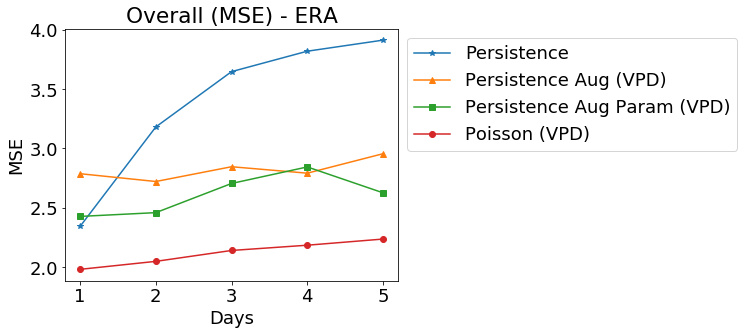

In [546]:
plt.rcParams['figure.figsize'] = [34,5]

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

results_dict = {'Persistence': persistence['summary_results'],
                'Persistence Aug (VPD)': p_vpd,
                'Persistence Aug Param (VPD)': p_param_vpd,
                'Poisson (VPD)': poisson_vpd,
}
measurements = [(r'Overall (MSE) - ERA','root_mean_squared_error', False, False),]

alpha = 0.0049727
plot_active_ignition(results_dict, measurements, baseline='Persistence', scale=True, markers=['*', '^', 's', 'o', 'x', 'd', 'v', 'p', 'P', '1'], y_labels = ['MSE', 'MSE SS %'], col_len=1)

In [532]:
poisson_weather = {'train': {'root_mean_squared_error': (['Avg.', 1, 2, 3, 4, 5], [1.4429735394303176, 1.3962829949869324, 1.419403347945718, 1.4504924969795066, 1.4650530212096229, 1.4836358360298072]), 'mean_absolute_error': (['Avg.', 1, 2, 3, 4, 5], [0.055094924662914546, 0.054978662732179495, 0.055208097803303935, 0.05523885845076866, 0.055095334838643074, 0.054953669489677615])}, 'test': {'root_mean_squared_error': (['Avg.', 1, 2, 3, 4, 5], [1.4545234414282691, 1.4074607283972198, 1.4312919574839416, 1.4617830313042817, 1.4771000252760633, 1.4949814646798394]), 'mean_absolute_error': (['Avg.', 1, 2, 3, 4, 5], [0.055139332828803247, 0.054842963171510294, 0.055157525330146707, 0.055351758639816957, 0.055304415058682617, 0.055040001943859669]), 'root_mean_squared_error_active': (['Avg.', 1, 2, 3, 4, 5], [17.469917440911455, 19.421983580806778, 18.295748480114725, 17.146024115828535, 16.506364556581595, 15.979466471225638], [0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763]), 'mean_absolute_error_active': (['Avg.', 1, 2, 3, 4, 5], [7.8094357365739011, 9.8786236877437936, 8.5991135497217837, 7.5239510600719735, 6.8195270613073973, 6.2259633240245611], [0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763]), 'root_mean_squared_error_ignition': (['Avg.', 1, 2, 3, 4, 5], [0.7333040757127034, 0.32511717534932794, 0.62127407772608678, 0.82357571081962411, 0.91164382752251272, 0.98490958714596566], [0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944]), 'mean_absolute_error_ignition': (['Avg.', 1, 2, 3, 4, 5], [0.016386821116979401, 0.0057480926943498647, 0.012458647358364057, 0.01802703350293873, 0.021499849992852007, 0.024200482036392339], [0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944]), 'root_mean_squared_error_active_target': (['Avg.', 1, 2, 3, 4, 5], [28.71870842020915, 26.809452900769671, 28.067953058634011, 28.770085221521605, 29.703568969914212, 30.242481950206255], [0.002378662659654395, 0.0019273729025795141, 0.0016083145504633108, 0.0014034560480841473, 0.0012787377911344855]), 'mean_absolute_error_active_target': (['Avg.', 1, 2, 3, 4, 5], [14.712805972826612, 13.895294762249032, 14.566637068414384, 14.832715913557085, 15.157741720391707, 15.111640399520859], [0.002378662659654395, 0.0019273729025795141, 0.0016083145504633108, 0.0014034560480841473, 0.0012787377911344855]), 'root_mean_squared_error_ignition_target': (['Avg.', 1, 2, 3, 4, 5], [16.687416759396218, 9.4394909721468974, 15.332960010388062, 18.574313490380323, 19.561423297126538, 20.528896026939272], [0.0011800651139494114, 0.0016333583771600301, 0.0019559228650137743, 0.0021607813673929378, 0.0022895066366140746]), 'mean_absolute_error_ignition_target': (['Avg.', 1, 2, 3, 4, 5], [8.3907605840069355, 4.8382852292020377, 7.5786568537258514, 9.1572343149807942, 9.8843300880853029, 10.495296434040691], [0.0011800651139494114, 0.0016333583771600301, 0.0019559228650137743, 0.0021607813673929378, 0.0022895066366140746]), 'root_mean_squared_error_zero_zero_target': (['Avg.', 1, 2, 3, 4, 5], [0.010710623272590144, 0.0052167786071629805, 0.0077784884776003534, 0.010068693937956459, 0.011884992884243597, 0.018604162455987332], [0.99384723265715003, 0.99339393939393938, 0.99307137490608566, 0.99286651640370649, 0.99273779113448535]), 'mean_absolute_error_zero_zero_target': (['Avg.', 1, 2, 3, 4, 5], [2.834781784485013e-05, 1.0079547791167896e-05, 1.8151464898848442e-05, 2.6731670018212843e-05, 3.5313263964630236e-05, 5.1463142551391242e-05], [0.99384723265715003, 0.99339393939393938, 0.99307137490608566, 0.99286651640370649, 0.99273779113448535]), 'root_mean_squared_error_extinction_target': (['Avg.', 1, 2, 3, 4, 5], [6.4170608451839239, 8.0023011242733322, 6.92713972128045, 6.2322257008352038, 5.7153617254373312, 5.2082759540933008], [0.0025940395692461808, 0.003045329326321062, 0.0033643876784372651, 0.0035692461808164285, 0.0036939644377660908]), 'mean_absolute_error_extinction_target': (['Avg.', 1, 2, 3, 4, 5], [4.3477394932624565, 6.1954472187680523, 4.8222993227597577, 4.0300633208222036, 3.5408745950213705, 3.1500130089408938], [0.0025940395692461808, 0.003045329326321062, 0.0033643876784372651, 0.0035692461808164285, 0.0036939644377660908])}}
poisson_ar = {'train': {'root_mean_squared_error': (['Avg.', 1, 2, 3, 4, 5], [1.4462060471158713, 1.28652642622505, 1.4288333056970275, 1.4864796146841719, 1.5089304363951717, 1.5202604525779357]), 'mean_absolute_error': (['Avg.', 1, 2, 3, 4, 5], [0.0560768609828559, 0.048317300559662463, 0.056403319606781278, 0.058588229656403416, 0.058737968013561341, 0.058337487077871023])}, 'test': {'root_mean_squared_error': (['Avg.', 1, 2, 3, 4, 5], [1.4559392400977029, 1.2903170590052178, 1.4391734657171846, 1.4998671256097331, 1.5201837110982055, 1.5301548390581727]), 'mean_absolute_error': (['Avg.', 1, 2, 3, 4, 5], [0.05592846244285752, 0.048123422505323282, 0.056212603506081968, 0.058516416420820783, 0.058641620410143841, 0.058148249371917718]), 'root_mean_squared_error_active': (['Avg.', 1, 2, 3, 4, 5], [17.567187663540629, 17.710475999402497, 18.419662602204827, 17.795177166515721, 17.275087667664828, 16.635534881915262], [0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763]), 'mean_absolute_error_active': (['Avg.', 1, 2, 3, 4, 5], [7.9681280486669053, 8.527338137779811, 8.8112875604243222, 8.1603571096060357, 7.4906320657586756, 6.851025369765682], [0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763]), 'root_mean_squared_error_ignition': (['Avg.', 1, 2, 3, 4, 5], [0.7333040757127034, 0.32511717534932794, 0.62127407772608678, 0.82357571081962411, 0.91164382752251272, 0.98490958714596566], [0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944]), 'mean_absolute_error_ignition': (['Avg.', 1, 2, 3, 4, 5], [0.016386821116979401, 0.0057480926943498647, 0.012458647358364057, 0.01802703350293873, 0.021499849992852007, 0.024200482036392339], [0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944]), 'root_mean_squared_error_active_target': (['Avg.', 1, 2, 3, 4, 5], [29.157710150760614, 24.595282806404409, 28.132528209480643, 29.973729977699602, 31.35386412696117, 31.733145633257227], [0.002378662659654395, 0.0019273729025795141, 0.0016083145504633108, 0.0014034560480841473, 0.0012787377911344855]), 'mean_absolute_error_active_target': (['Avg.', 1, 2, 3, 4, 5], [14.654670302938305, 13.243923467946836, 14.522266249298827, 15.027305055147892, 15.292674257120977, 15.187182485176985], [0.002378662659654395, 0.0019273729025795141, 0.0016083145504633108, 0.0014034560480841473, 0.0012787377911344855]), 'root_mean_squared_error_ignition_target': (['Avg.', 1, 2, 3, 4, 5], [16.687416759396218, 9.4394909721468974, 15.332960010388062, 18.574313490380323, 19.561423297126538, 20.528896026939272], [0.0011800651139494114, 0.0016333583771600301, 0.0019559228650137743, 0.0021607813673929378, 0.0022895066366140746]), 'mean_absolute_error_ignition_target': (['Avg.', 1, 2, 3, 4, 5], [8.3907605840069355, 4.8382852292020377, 7.5786568537258514, 9.1572343149807942, 9.8843300880853029, 10.495296434040691], [0.0011800651139494114, 0.0016333583771600301, 0.0019559228650137743, 0.0021607813673929378, 0.0022895066366140746]), 'root_mean_squared_error_zero_zero_target': (['Avg.', 1, 2, 3, 4, 5], [0.010710623272590144, 0.0052167786071629805, 0.0077784884776003534, 0.010068693937956459, 0.011884992884243597, 0.018604162455987332], [0.99384723265715003, 0.99339393939393938, 0.99307137490608566, 0.99286651640370649, 0.99273779113448535]), 'mean_absolute_error_zero_zero_target': (['Avg.', 1, 2, 3, 4, 5], [2.834781784485013e-05, 1.0079547791167896e-05, 1.8151464898848442e-05, 2.6731670018212843e-05, 3.5313263964630236e-05, 5.1463142551391242e-05], [0.99384723265715003, 0.99339393939393938, 0.99307137490608566, 0.99286651640370649, 0.99273779113448535]), 'root_mean_squared_error_extinction_target': (['Avg.', 1, 2, 3, 4, 5], [6.1245683178893566, 6.8247480004020256, 7.288164453548224, 6.2100849969265299, 5.4059472692188137, 4.8938968693511891], [0.0025940395692461808, 0.003045329326321062, 0.0033643876784372651, 0.0035692461808164285, 0.0036939644377660908]), 'mean_absolute_error_extinction_target': (['Avg.', 1, 2, 3, 4, 5], [4.5329967380768039, 4.2023596220502837, 5.1968392060182236, 4.8776758749573963, 4.4228068875104078, 3.9653020998477069], [0.0025940395692461808, 0.003045329326321062, 0.0033643876784372651, 0.0035692461808164285, 0.0036939644377660908])}}
poisson_weather_ar = {'train': {'root_mean_squared_error': (['Avg.', 1, 2, 3, 4, 5], [1.394109064224843, 1.2740700234075593, 1.3684523851750863, 1.4241188619745673, 1.4415768617912237, 1.4623271887757789]), 'mean_absolute_error': (['Avg.', 1, 2, 3, 4, 5], [0.052015042785717044, 0.047415508932023509, 0.052278729664310214, 0.05341729752535869, 0.053419063621283645, 0.053544614185609164])}, 'test': {'root_mean_squared_error': (['Avg.', 1, 2, 3, 4, 5], [1.4082159482823706, 1.2872167864994544, 1.3814227022998298, 1.4374819699753107, 1.4567008737725347, 1.4782574088647229]), 'mean_absolute_error': (['Avg.', 1, 2, 3, 4, 5], [0.052258591210410911, 0.047566959913154717, 0.052411057392903339, 0.053547476922043293, 0.053869042098592897, 0.053898419725360303]), 'root_mean_squared_error_active': (['Avg.', 1, 2, 3, 4, 5], [16.740370652710624, 17.66504953974173, 17.507907199648546, 16.727753780198388, 16.137687402515429, 15.663455341449033], [0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763]), 'mean_absolute_error_active': (['Avg.', 1, 2, 3, 4, 5], [7.2301246325126254, 8.4154346763309178, 8.046804601624844, 7.1611137867505468, 6.5308765662611528, 5.9963935315956665], [0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763]), 'root_mean_squared_error_ignition': (['Avg.', 1, 2, 3, 4, 5], [0.7333040757127034, 0.32511717534932794, 0.62127407772608678, 0.82357571081962411, 0.91164382752251272, 0.98490958714596566], [0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944]), 'mean_absolute_error_ignition': (['Avg.', 1, 2, 3, 4, 5], [0.016386821116979401, 0.0057480926943498647, 0.012458647358364057, 0.01802703350293873, 0.021499849992852007, 0.024200482036392339], [0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944]), 'root_mean_squared_error_active_target': (['Avg.', 1, 2, 3, 4, 5], [27.674754408492824, 24.605973180539152, 26.895770335086301, 28.152772770880386, 29.116991655390713, 29.602264100567552], [0.002378662659654395, 0.0019273729025795141, 0.0016083145504633108, 0.0014034560480841473, 0.0012787377911344855]), 'mean_absolute_error_active_target': (['Avg.', 1, 2, 3, 4, 5], [14.531539183391626, 13.279519120720805, 14.445048328619658, 14.783982927131619, 15.134870012178904, 15.014275528307158], [0.002378662659654395, 0.0019273729025795141, 0.0016083145504633108, 0.0014034560480841473, 0.0012787377911344855]), 'root_mean_squared_error_ignition_target': (['Avg.', 1, 2, 3, 4, 5], [16.687416759396218, 9.4394909721468974, 15.332960010388062, 18.574313490380323, 19.561423297126538, 20.528896026939272], [0.0011800651139494114, 0.0016333583771600301, 0.0019559228650137743, 0.0021607813673929378, 0.0022895066366140746]), 'mean_absolute_error_ignition_target': (['Avg.', 1, 2, 3, 4, 5], [8.3907605840069355, 4.8382852292020377, 7.5786568537258514, 9.1572343149807942, 9.8843300880853029, 10.495296434040691], [0.0011800651139494114, 0.0016333583771600301, 0.0019559228650137743, 0.0021607813673929378, 0.0022895066366140746]), 'root_mean_squared_error_zero_zero_target': (['Avg.', 1, 2, 3, 4, 5], [0.010710623272590144, 0.0052167786071629805, 0.0077784884776003534, 0.010068693937956459, 0.011884992884243597, 0.018604162455987332], [0.99384723265715003, 0.99339393939393938, 0.99307137490608566, 0.99286651640370649, 0.99273779113448535]), 'mean_absolute_error_zero_zero_target': (['Avg.', 1, 2, 3, 4, 5], [2.834781784485013e-05, 1.0079547791167896e-05, 1.8151464898848442e-05, 2.6731670018212843e-05, 3.5313263964630236e-05, 5.1463142551391242e-05], [0.99384723265715003, 0.99339393939393938, 0.99307137490608566, 0.99286651640370649, 0.99273779113448535]), 'root_mean_squared_error_extinction_target': (['Avg.', 1, 2, 3, 4, 5], [5.9201873295369305, 6.5585311337842258, 6.5346055156536629, 5.8904274038271254, 5.4281413391181106, 5.1892312553015278], [0.0025940395692461808, 0.003045329326321062, 0.0033643876784372651, 0.0035692461808164285, 0.0036939644377660908]), 'mean_absolute_error_extinction_target': (['Avg.', 1, 2, 3, 4, 5], [3.4984120842804756, 3.9552035455320023, 3.9973898217768093, 3.5170713854160804, 3.1477177625197066, 2.8746779061577783], [0.0025940395692461808, 0.003045329326321062, 0.0033643876784372651, 0.0035692461808164285, 0.0036939644377660908])}}
poisson_weather_ar_mem = {'train': {'root_mean_squared_error': (['Avg.', 1, 2, 3, 4, 5], [1.3865841665404901, 1.2680493370245183, 1.3528230817057485, 1.4146666310328124, 1.4363119425169495, 1.4610698404224212]), 'mean_absolute_error': (['Avg.', 1, 2, 3, 4, 5], [0.051376023014653702, 0.047127228922112276, 0.051256214426873954, 0.052675804290723938, 0.052784396104377837, 0.053036471329180497])}, 'test': {'root_mean_squared_error': (['Avg.', 1, 2, 3, 4, 5], [1.4164226960809172, 1.3009072058652533, 1.380857070306106, 1.4415703471695718, 1.470092433483045, 1.4886864235806103]), 'mean_absolute_error': (['Avg.', 1, 2, 3, 4, 5], [0.051890077760076189, 0.047618129554090068, 0.05160258458421059, 0.053149222999035454, 0.053492977958475879, 0.053587473704568941]), 'root_mean_squared_error_active': (['Avg.', 1, 2, 3, 4, 5], [16.880759252870689, 17.865591994831252, 17.498931748673673, 16.798357061163681, 16.380074841490444, 15.860840618194407], [0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763]), 'mean_absolute_error_active': (['Avg.', 1, 2, 3, 4, 5], [7.1560173497171764, 8.4257247839182927, 7.884222413615678, 7.0810257572093365, 6.4552508555698163, 5.933862938272755], [0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763]), 'root_mean_squared_error_ignition': (['Avg.', 1, 2, 3, 4, 5], [0.7333040757127034, 0.32511717534932794, 0.62127407772608678, 0.82357571081962411, 0.91164382752251272, 0.98490958714596566], [0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944]), 'mean_absolute_error_ignition': (['Avg.', 1, 2, 3, 4, 5], [0.016386821116979401, 0.0057480926943498647, 0.012458647358364057, 0.01802703350293873, 0.021499849992852007, 0.024200482036392339], [0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944]), 'root_mean_squared_error_active_target': (['Avg.', 1, 2, 3, 4, 5], [27.970678949598057, 24.92498507278113, 26.934033457470658, 28.331667947053479, 29.620546736323966, 30.042161534361039], [0.002378662659654395, 0.0019273729025795141, 0.0016083145504633108, 0.0014034560480841473, 0.0012787377911344855]), 'mean_absolute_error_active_target': (['Avg.', 1, 2, 3, 4, 5], [14.592003935102809, 13.378353035127621, 14.374357782631662, 14.817517997440721, 15.255087602349306, 15.134703257964736], [0.002378662659654395, 0.0019273729025795141, 0.0016083145504633108, 0.0014034560480841473, 0.0012787377911344855]), 'root_mean_squared_error_ignition_target': (['Avg.', 1, 2, 3, 4, 5], [16.687416759396218, 9.4394909721468974, 15.332960010388062, 18.574313490380323, 19.561423297126538, 20.528896026939272], [0.0011800651139494114, 0.0016333583771600301, 0.0019559228650137743, 0.0021607813673929378, 0.0022895066366140746]), 'mean_absolute_error_ignition_target': (['Avg.', 1, 2, 3, 4, 5], [8.3907605840069355, 4.8382852292020377, 7.5786568537258514, 9.1572343149807942, 9.8843300880853029, 10.495296434040691], [0.0011800651139494114, 0.0016333583771600301, 0.0019559228650137743, 0.0021607813673929378, 0.0022895066366140746]), 'root_mean_squared_error_zero_zero_target': (['Avg.', 1, 2, 3, 4, 5], [0.010710623272590144, 0.0052167786071629805, 0.0077784884776003534, 0.010068693937956459, 0.011884992884243597, 0.018604162455987332], [0.99384723265715003, 0.99339393939393938, 0.99307137490608566, 0.99286651640370649, 0.99273779113448535]), 'mean_absolute_error_zero_zero_target': (['Avg.', 1, 2, 3, 4, 5], [2.834781784485013e-05, 1.0079547791167896e-05, 1.8151464898848442e-05, 2.6731670018212843e-05, 3.5313263964630236e-05, 5.1463142551391242e-05], [0.99384723265715003, 0.99339393939393938, 0.99307137490608566, 0.99286651640370649, 0.99273779113448535]), 'root_mean_squared_error_extinction_target': (['Avg.', 1, 2, 3, 4, 5], [5.8308163329899418, 6.4949581467663249, 6.3940940866122773, 5.7762646063228713, 5.3680254978554682, 5.1207393273927657], [0.0025940395692461808, 0.003045329326321062, 0.0033643876784372651, 0.0035692461808164285, 0.0036939644377660908]), 'mean_absolute_error_extinction_target': (['Avg.', 1, 2, 3, 4, 5], [3.3575031663190442, 3.8843014270939853, 3.7766498971726672, 3.3826668792306274, 2.9950849048995765, 2.7488127231983648], [0.0025940395692461808, 0.003045329326321062, 0.0033643876784372651, 0.0035692461808164285, 0.0036939644377660908])}}

hurdle_weather_ar = {'train': {'root_mean_squared_error': (['Avg.', 1, 2, 3, 4, 5], [1.3923968389780925, 1.2677210924456248, 1.3690736183991055, 1.4212272689911942, 1.440662100790649, 1.4633001142638884]), 'mean_absolute_error': (['Avg.', 1, 2, 3, 4, 5], [0.051885872747514848, 0.047170523211203318, 0.052191619309113736, 0.053307946541947142, 0.053269620057250854, 0.053489654618059171])}, 'test': {'root_mean_squared_error': (['Avg.', 1, 2, 3, 4, 5], [1.4074404024018212, 1.2788268408869112, 1.3849926836560498, 1.4377475441761549, 1.4554998835473973, 1.4801350597425929]), 'mean_absolute_error': (['Avg.', 1, 2, 3, 4, 5], [0.052135553048179684, 0.047269868886453625, 0.052367774412306563, 0.053526836792335331, 0.053671457252411466, 0.053841827897391427]), 'root_mean_squared_error_active': (['Avg.', 1, 2, 3, 4, 5], [16.730782091774966, 17.542079272103923, 17.564534373193993, 16.732342998896289, 16.115880671659625, 15.699073143021012], [0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763]), 'mean_absolute_error_active': (['Avg.', 1, 2, 3, 4, 5], [7.2053819158632866, 8.3556902932921684, 8.0381004849083393, 7.1569630999090927, 6.491142667651034, 5.9850130335558003], [0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763]), 'root_mean_squared_error_ignition': (['Avg.', 1, 2, 3, 4, 5], [0.7333040757127034, 0.32511717534932794, 0.62127407772608678, 0.82357571081962411, 0.91164382752251272, 0.98490958714596566], [0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944]), 'mean_absolute_error_ignition': (['Avg.', 1, 2, 3, 4, 5], [0.016386821116979401, 0.0057480926943498647, 0.012458647358364057, 0.01802703350293873, 0.021499849992852007, 0.024200482036392339], [0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944]), 'root_mean_squared_error_active_target': (['Avg.', 1, 2, 3, 4, 5], [27.610451618083726, 24.356490928989295, 26.933582268966116, 28.089142763970258, 29.022656799035872, 29.650385329457094], [0.002378662659654395, 0.0019273729025795141, 0.0016083145504633108, 0.0014034560480841473, 0.0012787377911344855]), 'mean_absolute_error_active_target': (['Avg.', 1, 2, 3, 4, 5], [14.48097861341299, 13.275674156064346, 14.462689404651222, 14.765202823600717, 14.969644999853614, 14.931681682895046], [0.002378662659654395, 0.0019273729025795141, 0.0016083145504633108, 0.0014034560480841473, 0.0012787377911344855]), 'root_mean_squared_error_ignition_target': (['Avg.', 1, 2, 3, 4, 5], [16.687416759396218, 9.4394909721468974, 15.332960010388062, 18.574313490380323, 19.561423297126538, 20.528896026939272], [0.0011800651139494114, 0.0016333583771600301, 0.0019559228650137743, 0.0021607813673929378, 0.0022895066366140746]), 'mean_absolute_error_ignition_target': (['Avg.', 1, 2, 3, 4, 5], [8.3907605840069355, 4.8382852292020377, 7.5786568537258514, 9.1572343149807942, 9.8843300880853029, 10.495296434040691], [0.0011800651139494114, 0.0016333583771600301, 0.0019559228650137743, 0.0021607813673929378, 0.0022895066366140746]), 'root_mean_squared_error_zero_zero_target': (['Avg.', 1, 2, 3, 4, 5], [0.010710623272590144, 0.0052167786071629805, 0.0077784884776003534, 0.010068693937956459, 0.011884992884243597, 0.018604162455987332], [0.99384723265715003, 0.99339393939393938, 0.99307137490608566, 0.99286651640370649, 0.99273779113448535]), 'mean_absolute_error_zero_zero_target': (['Avg.', 1, 2, 3, 4, 5], [2.834781784485013e-05, 1.0079547791167896e-05, 1.8151464898848442e-05, 2.6731670018212843e-05, 3.5313263964630236e-05, 5.1463142551391242e-05], [0.99384723265715003, 0.99339393939393938, 0.99307137490608566, 0.99286651640370649, 0.99273779113448535]), 'root_mean_squared_error_extinction_target': (['Avg.', 1, 2, 3, 4, 5], [6.0571127316372833, 6.7761341640340769, 6.6825067367135507, 6.0526728387362274, 5.5354673993475387, 5.2387825193550199], [0.0025940395692461808, 0.003045329326321062, 0.0033643876784372651, 0.0035692461808164285, 0.0036939644377660908]), 'mean_absolute_error_extinction_target': (['Avg.', 1, 2, 3, 4, 5], [3.4762808667008955, 3.8442009393039318, 3.9720119712289614, 3.5199141565156418, 3.1573279700883585, 2.8879492963675832], [0.0025940395692461808, 0.003045329326321062, 0.0033643876784372651, 0.0035692461808164285, 0.0036939644377660908])}}
hurdle_weather_ar_mem = {'train': {'root_mean_squared_error': (['Avg.', 1, 2, 3, 4, 5], [1.3809058702935038, 1.2594099749541756, 1.3474775023915166, 1.4090587463999371, 1.4314019321016132, 1.4571811956202756]), 'mean_absolute_error': (['Avg.', 1, 2, 3, 4, 5], [0.051217803131697437, 0.046893045205408275, 0.05105719847476, 0.052551149094986836, 0.052644068344582746, 0.052943554538749306])}, 'test': {'root_mean_squared_error': (['Avg.', 1, 2, 3, 4, 5], [1.4056012761542518, 1.2863462631411993, 1.3726748148293497, 1.4333599042236629, 1.4543348312800992, 1.4812905672969479]), 'mean_absolute_error': (['Avg.', 1, 2, 3, 4, 5], [0.051620933553675752, 0.047251035537985091, 0.051340579496097681, 0.052957538219799226, 0.053138007178873632, 0.053417507335623129]), 'root_mean_squared_error_active': (['Avg.', 1, 2, 3, 4, 5], [16.698688869114235, 17.65229294465993, 17.368991224772131, 16.656470044738771, 16.094715464985978, 15.720974666414364], [0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763]), 'mean_absolute_error_active': (['Avg.', 1, 2, 3, 4, 5], [7.1018930136899332, 8.3519029463726113, 7.8315337393189983, 7.0424783497007608, 6.3838669754856205, 5.8996830575716714], [0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763]), 'root_mean_squared_error_ignition': (['Avg.', 1, 2, 3, 4, 5], [0.7333040757127034, 0.32511717534932794, 0.62127407772608678, 0.82357571081962411, 0.91164382752251272, 0.98490958714596566], [0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944]), 'mean_absolute_error_ignition': (['Avg.', 1, 2, 3, 4, 5], [0.016386821116979401, 0.0057480926943498647, 0.012458647358364057, 0.01802703350293873, 0.021499849992852007, 0.024200482036392339], [0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944]), 'root_mean_squared_error_active_target': (['Avg.', 1, 2, 3, 4, 5], [27.594788364779266, 24.545015767005196, 26.674584091411198, 27.994036556142877, 29.028638978542538, 29.731666430794515], [0.002378662659654395, 0.0019273729025795141, 0.0016083145504633108, 0.0014034560480841473, 0.0012787377911344855]), 'mean_absolute_error_active_target': (['Avg.', 1, 2, 3, 4, 5], [14.461679973332281, 13.322181436045092, 14.316024498258463, 14.679945264349284, 15.000558961410455, 14.98968970659811], [0.002378662659654395, 0.0019273729025795141, 0.0016083145504633108, 0.0014034560480841473, 0.0012787377911344855]), 'root_mean_squared_error_ignition_target': (['Avg.', 1, 2, 3, 4, 5], [16.687416759396218, 9.4394909721468974, 15.332960010388062, 18.574313490380323, 19.561423297126538, 20.528896026939272], [0.0011800651139494114, 0.0016333583771600301, 0.0019559228650137743, 0.0021607813673929378, 0.0022895066366140746]), 'mean_absolute_error_ignition_target': (['Avg.', 1, 2, 3, 4, 5], [8.3907605840069355, 4.8382852292020377, 7.5786568537258514, 9.1572343149807942, 9.8843300880853029, 10.495296434040691], [0.0011800651139494114, 0.0016333583771600301, 0.0019559228650137743, 0.0021607813673929378, 0.0022895066366140746]), 'root_mean_squared_error_zero_zero_target': (['Avg.', 1, 2, 3, 4, 5], [0.010710623272590144, 0.0052167786071629805, 0.0077784884776003534, 0.010068693937956459, 0.011884992884243597, 0.018604162455987332], [0.99384723265715003, 0.99339393939393938, 0.99307137490608566, 0.99286651640370649, 0.99273779113448535]), 'mean_absolute_error_zero_zero_target': (['Avg.', 1, 2, 3, 4, 5], [2.834781784485013e-05, 1.0079547791167896e-05, 1.8151464898848442e-05, 2.6731670018212843e-05, 3.5313263964630236e-05, 5.1463142551391242e-05], [0.99384723265715003, 0.99339393939393938, 0.99307137490608566, 0.99286651640370649, 0.99273779113448535]), 'root_mean_squared_error_extinction_target': (['Avg.', 1, 2, 3, 4, 5], [5.95209333114017, 6.7005996459429928, 6.5029953189533343, 5.95317713922379, 5.4364545101802335, 5.1672400414005013], [0.0025940395692461808, 0.003045329326321062, 0.0033643876784372651, 0.0035692461808164285, 0.0036939644377660908]), 'mean_absolute_error_extinction_target': (['Avg.', 1, 2, 3, 4, 5], [3.3324002348834356, 3.7942948082272903, 3.7275336668849435, 3.391457616793748, 2.9957150045957261, 2.7530000779154689], [0.0025940395692461808, 0.003045329326321062, 0.0033643876784372651, 0.0035692461808164285, 0.0036939644377660908])}}
hurdle_weather_vpd_ar = {'train': {'root_mean_squared_error': (['Avg.', 1, 2, 3, 4, 5], [1.3907766849768828, 1.2664740133233283, 1.3666998607061676, 1.4206886173904101, 1.4389153862452624, 1.4611055472192456]), 'mean_absolute_error': (['Avg.', 1, 2, 3, 4, 5], [0.051879133145857112, 0.047138332158150227, 0.052170479195800236, 0.053319362637232262, 0.053279979677232227, 0.053487512060870636])}, 'test': {'root_mean_squared_error': (['Avg.', 1, 2, 3, 4, 5], [1.4106392663439129, 1.2838271432312212, 1.387147906442197, 1.4420166948784408, 1.4579643191339422, 1.482240268033763]), 'mean_absolute_error': (['Avg.', 1, 2, 3, 4, 5], [0.052176725885568986, 0.047326742835632402, 0.052377562960137992, 0.053589501639092305, 0.053706167680567587, 0.053883654312414639]), 'root_mean_squared_error_active': (['Avg.', 1, 2, 3, 4, 5], [16.783943569984547, 17.615374612433179, 17.598702889182505, 16.806059310332859, 16.160615761843989, 15.738965276130209], [0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763]), 'mean_absolute_error_active': (['Avg.', 1, 2, 3, 4, 5], [7.2136616872017001, 8.3671275253162936, 8.0400689413694106, 7.1695648693037661, 6.4981228620319458, 5.9934242379870861], [0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763]), 'root_mean_squared_error_ignition': (['Avg.', 1, 2, 3, 4, 5], [0.7333040757127034, 0.32511717534932794, 0.62127407772608678, 0.82357571081962411, 0.91164382752251272, 0.98490958714596566], [0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944]), 'mean_absolute_error_ignition': (['Avg.', 1, 2, 3, 4, 5], [0.016386821116979401, 0.0057480926943498647, 0.012458647358364057, 0.01802703350293873, 0.021499849992852007, 0.024200482036392339], [0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944]), 'root_mean_squared_error_active_target': (['Avg.', 1, 2, 3, 4, 5], [27.7153550632754, 24.473275307335363, 27.012202391040852, 28.239245744322226, 29.120778049974504, 29.731273823704061], [0.002378662659654395, 0.0019273729025795141, 0.0016083145504633108, 0.0014034560480841473, 0.0012787377911344855]), 'mean_absolute_error_active_target': (['Avg.', 1, 2, 3, 4, 5], [14.507678811057229, 13.290817094209814, 14.456519951352057, 14.792001439927345, 15.008816987164055, 14.990238582632882], [0.002378662659654395, 0.0019273729025795141, 0.0016083145504633108, 0.0014034560480841473, 0.0012787377911344855]), 'root_mean_squared_error_ignition_target': (['Avg.', 1, 2, 3, 4, 5], [16.687416759396218, 9.4394909721468974, 15.332960010388062, 18.574313490380323, 19.561423297126538, 20.528896026939272], [0.0011800651139494114, 0.0016333583771600301, 0.0019559228650137743, 0.0021607813673929378, 0.0022895066366140746]), 'mean_absolute_error_ignition_target': (['Avg.', 1, 2, 3, 4, 5], [8.3907605840069355, 4.8382852292020377, 7.5786568537258514, 9.1572343149807942, 9.8843300880853029, 10.495296434040691], [0.0011800651139494114, 0.0016333583771600301, 0.0019559228650137743, 0.0021607813673929378, 0.0022895066366140746]), 'root_mean_squared_error_zero_zero_target': (['Avg.', 1, 2, 3, 4, 5], [0.010710623272590144, 0.0052167786071629805, 0.0077784884776003534, 0.010068693937956459, 0.011884992884243597, 0.018604162455987332], [0.99384723265715003, 0.99339393939393938, 0.99307137490608566, 0.99286651640370649, 0.99273779113448535]), 'mean_absolute_error_zero_zero_target': (['Avg.', 1, 2, 3, 4, 5], [2.834781784485013e-05, 1.0079547791167896e-05, 1.8151464898848442e-05, 2.6731670018212843e-05, 3.5313263964630236e-05, 5.1463142551391242e-05], [0.99384723265715003, 0.99339393939393938, 0.99307137490608566, 0.99286651640370649, 0.99273779113448535]), 'root_mean_squared_error_extinction_target': (['Avg.', 1, 2, 3, 4, 5], [6.0318553468151501, 6.7547548327751681, 6.6282374028127693, 6.020563595703976, 5.514503401836425, 5.2412175009474105], [0.0025940395692461808, 0.003045329326321062, 0.0033643876784372651, 0.0035692461808164285, 0.0036939644377660908]), 'mean_absolute_error_extinction_target': (['Avg.', 1, 2, 3, 4, 5], [3.4775503897773943, 3.852240141134919, 3.9791308679461848, 3.5257292539587741, 3.1516500948946797, 2.8790015909524129], [0.0025940395692461808, 0.003045329326321062, 0.0033643876784372651, 0.0035692461808164285, 0.0036939644377660908])}}

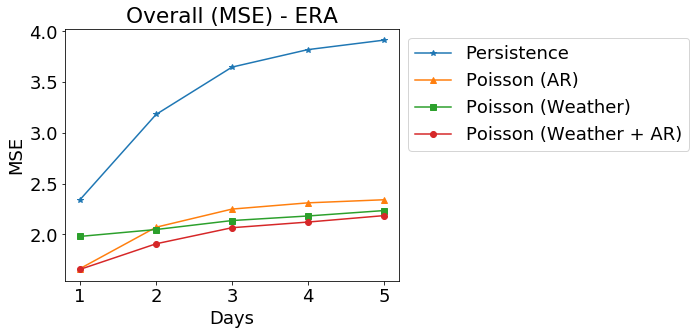

In [543]:
plt.rcParams['figure.figsize'] = [32,5]

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

results_dict = {'Persistence': persistence['summary_results'],
                'Poisson (AR)': poisson_ar,
                'Poisson (Weather)': poisson_weather,
                'Poisson (Weather + AR)': poisson_weather_ar,
                #'Poisson (Weather + AR + Mem)': poisson_weather_ar,
                #'Hurdle (Weather + AR)': hurdle_weather_ar,
                #'Hurdle (Weather + AR + Mem)': hurdle_weather_ar_mem,
}
measurements = [(r'Overall (MSE) - ERA','root_mean_squared_error', False, False),]

alpha = 0.0049727
plot_active_ignition(results_dict, measurements, baseline='Persistence', scale=True, markers=['*', '^', 's', 'o', 'x', 'd', 'v', 'p', 'P', '1'], y_labels = ['MSE', 'MSE SS %'], col_len=1)

In [547]:
large_split_90_true = {'train': {'root_mean_squared_error': (['Avg.', 1, 2, 3, 4, 5], [1.3812595711480358, 1.2568424578893478, 1.3475364993289896, 1.4118907079181893, 1.4323620913433677, 1.4576660992602843]), 'mean_absolute_error': (['Avg.', 1, 2, 3, 4, 5], [0.051343775044905435, 0.047008111921793383, 0.051204847263352629, 0.052721876680160047, 0.05275755017645193, 0.053026489182769226])}, 'test': {'root_mean_squared_error': (['Avg.', 1, 2, 3, 4, 5], [1.4046831967242206, 1.2851604766774858, 1.370095845406738, 1.4337068415021732, 1.453414520969174, 1.4810382990655315]), 'mean_absolute_error': (['Avg.', 1, 2, 3, 4, 5], [0.051800948148517878, 0.047512582726204566, 0.051506904354042038, 0.053112433412163131, 0.053342949621579053, 0.053529870628600602]), 'root_mean_squared_error_active': (['Avg.', 1, 2, 3, 4, 5], [16.683913287012043, 17.634915560676429, 17.327994280320151, 16.662473552738117, 16.077988727710871, 15.716194313614656], [0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763]), 'mean_absolute_error_active': (['Avg.', 1, 2, 3, 4, 5], [7.1380935715668743, 8.4044995379600564, 7.8649813197869554, 7.0736274483666097, 6.4250804713419187, 5.9222790803788339], [0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763]), 'root_mean_squared_error_ignition': (['Avg.', 1, 2, 3, 4, 5], [0.7333040757127034, 0.32511717534932794, 0.62127407772608678, 0.82357571081962411, 0.91164382752251272, 0.98490958714596566], [0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944]), 'mean_absolute_error_ignition': (['Avg.', 1, 2, 3, 4, 5], [0.016386821116979401, 0.0057480926943498647, 0.012458647358364057, 0.01802703350293873, 0.021499849992852007, 0.024200482036392339], [0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944]), 'root_mean_squared_error_active_target': (['Avg.', 1, 2, 3, 4, 5], [27.541170886370811, 24.502572924487712, 26.585410651872724, 27.973986553775624, 28.945584314450318, 29.698299987267674], [0.002378662659654395, 0.0019273729025795141, 0.0016083145504633108, 0.0014034560480841473, 0.0012787377911344855]), 'mean_absolute_error_active_target': (['Avg.', 1, 2, 3, 4, 5], [14.512320125331934, 13.308421586930033, 14.319276827754857, 14.749414903945652, 15.122014797209852, 15.062472510819271], [0.002378662659654395, 0.0019273729025795141, 0.0016083145504633108, 0.0014034560480841473, 0.0012787377911344855]), 'root_mean_squared_error_ignition_target': (['Avg.', 1, 2, 3, 4, 5], [16.687416759396218, 9.4394909721468974, 15.332960010388062, 18.574313490380323, 19.561423297126538, 20.528896026939272], [0.0011800651139494114, 0.0016333583771600301, 0.0019559228650137743, 0.0021607813673929378, 0.0022895066366140746]), 'mean_absolute_error_ignition_target': (['Avg.', 1, 2, 3, 4, 5], [8.3907605840069355, 4.8382852292020377, 7.5786568537258514, 9.1572343149807942, 9.8843300880853029, 10.495296434040691], [0.0011800651139494114, 0.0016333583771600301, 0.0019559228650137743, 0.0021607813673929378, 0.0022895066366140746]), 'root_mean_squared_error_zero_zero_target': (['Avg.', 1, 2, 3, 4, 5], [0.010710623272590144, 0.0052167786071629805, 0.0077784884776003534, 0.010068693937956459, 0.011884992884243597, 0.018604162455987332], [0.99384723265715003, 0.99339393939393938, 0.99307137490608566, 0.99286651640370649, 0.99273779113448535]), 'mean_absolute_error_zero_zero_target': (['Avg.', 1, 2, 3, 4, 5], [2.834781784485013e-05, 1.0079547791167896e-05, 1.8151464898848442e-05, 2.6731670018212843e-05, 3.5313263964630236e-05, 5.1463142551391242e-05], [0.99384723265715003, 0.99339393939393938, 0.99307137490608566, 0.99286651640370649, 0.99273779113448535]), 'root_mean_squared_error_extinction_target': (['Avg.', 1, 2, 3, 4, 5], [6.0175155492640462, 6.7551038681918891, 6.5553077247404881, 6.0226579788679171, 5.540631611076237, 5.2138765634437014], [0.0025940395692461808, 0.003045329326321062, 0.0033643876784372651, 0.0035692461808164285, 0.0036939644377660908]), 'mean_absolute_error_extinction_target': (['Avg.', 1, 2, 3, 4, 5], [3.3711435122279214, 3.9077384237375381, 3.7800916627704289, 3.4042879337225274, 3.0053765727898631, 2.7582229681192501], [0.0025940395692461808, 0.003045329326321062, 0.0033643876784372651, 0.0035692461808164285, 0.0036939644377660908])}}
large_split_90_oracle = {'train': {'root_mean_squared_error': (['Avg.', 1, 2, 3, 4, 5], [1.2967775693268433, 1.1911340977138232, 1.259941960204046, 1.3192350445994487, 1.3430711157269226, 1.3705056283899759]), 'mean_absolute_error': (['Avg.', 1, 2, 3, 4, 5], [0.047800512121437475, 0.045114245340258374, 0.047988470354511259, 0.048608526271748068, 0.048512980614167964, 0.048778338026501715])}, 'test': {'root_mean_squared_error': (['Avg.', 1, 2, 3, 4, 5], [1.3265822145888504, 1.2238007166075935, 1.2892777546772485, 1.3466916086009177, 1.3692847576280536, 1.40385623543044]), 'mean_absolute_error': (['Avg.', 1, 2, 3, 4, 5], [0.048321338541259341, 0.045656365318232285, 0.04842786606537644, 0.049111395647756961, 0.0490423180189061, 0.049368747656024926]), 'root_mean_squared_error_active': (['Avg.', 1, 2, 3, 4, 5], [15.327276746936226, 16.734137976527158, 16.032414622890858, 15.132250239632429, 14.517106952545474, 14.220473943085212], [0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763]), 'mean_absolute_error_active': (['Avg.', 1, 2, 3, 4, 5], [6.4383513696237173, 8.0312181061493551, 7.2457931707820364, 6.2690271364571668, 5.5602324662314659, 5.0854859684985643], [0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763, 0.0049727022289005763]), 'root_mean_squared_error_ignition': (['Avg.', 1, 2, 3, 4, 5], [0.7333040757127034, 0.32511717534932794, 0.62127407772608678, 0.82357571081962411, 0.91164382752251272, 0.98490958714596566], [0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944]), 'mean_absolute_error_ignition': (['Avg.', 1, 2, 3, 4, 5], [0.016386821116979401, 0.0057480926943498647, 0.012458647358364057, 0.01802703350293873, 0.021499849992852007, 0.024200482036392339], [0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944, 0.99502729777109944]), 'root_mean_squared_error_active_target': (['Avg.', 1, 2, 3, 4, 5], [25.87548684720992, 23.61188488529843, 25.163718644848814, 26.09498434012918, 26.873983447796054, 27.632862917977118], [0.002378662659654395, 0.0019273729025795141, 0.0016083145504633108, 0.0014034560480841473, 0.0012787377911344855]), 'mean_absolute_error_active_target': (['Avg.', 1, 2, 3, 4, 5], [14.241991286084167, 13.182827270686506, 14.062351524073593, 14.400111881978724, 14.730562109427119, 14.834103644254887], [0.002378662659654395, 0.0019273729025795141, 0.0016083145504633108, 0.0014034560480841473, 0.0012787377911344855]), 'root_mean_squared_error_ignition_target': (['Avg.', 1, 2, 3, 4, 5], [16.687416759396218, 9.4394909721468974, 15.332960010388062, 18.574313490380323, 19.561423297126538, 20.528896026939272], [0.0011800651139494114, 0.0016333583771600301, 0.0019559228650137743, 0.0021607813673929378, 0.0022895066366140746]), 'mean_absolute_error_ignition_target': (['Avg.', 1, 2, 3, 4, 5], [8.3907605840069355, 4.8382852292020377, 7.5786568537258514, 9.1572343149807942, 9.8843300880853029, 10.495296434040691], [0.0011800651139494114, 0.0016333583771600301, 0.0019559228650137743, 0.0021607813673929378, 0.0022895066366140746]), 'root_mean_squared_error_zero_zero_target': (['Avg.', 1, 2, 3, 4, 5], [0.010710623272590144, 0.0052167786071629805, 0.0077784884776003534, 0.010068693937956459, 0.011884992884243597, 0.018604162455987332], [0.99384723265715003, 0.99339393939393938, 0.99307137490608566, 0.99286651640370649, 0.99273779113448535]), 'mean_absolute_error_zero_zero_target': (['Avg.', 1, 2, 3, 4, 5], [2.834781784485013e-05, 1.0079547791167896e-05, 1.8151464898848442e-05, 2.6731670018212843e-05, 3.5313263964630236e-05, 5.1463142551391242e-05], [0.99384723265715003, 0.99339393939393938, 0.99307137490608566, 0.99286651640370649, 0.99273779113448535]), 'root_mean_squared_error_extinction_target': (['Avg.', 1, 2, 3, 4, 5], [3.7843911188468069, 5.0577613261120913, 4.3542519145299146, 3.5955731466330345, 3.1039394127188493, 2.8104297942401448], [0.0025940395692461808, 0.003045329326321062, 0.0033643876784372651, 0.0035692461808164285, 0.0036939644377660908]), 'mean_absolute_error_extinction_target': (['Avg.', 1, 2, 3, 4, 5], [2.4572397312930523, 3.3073347459665117, 2.9316292656067229, 2.3820369447242915, 1.9543857555614959, 1.71081194460624], [0.0025940395692461808, 0.003045329326321062, 0.0033643876784372651, 0.0035692461808164285, 0.0036939644377660908])}}

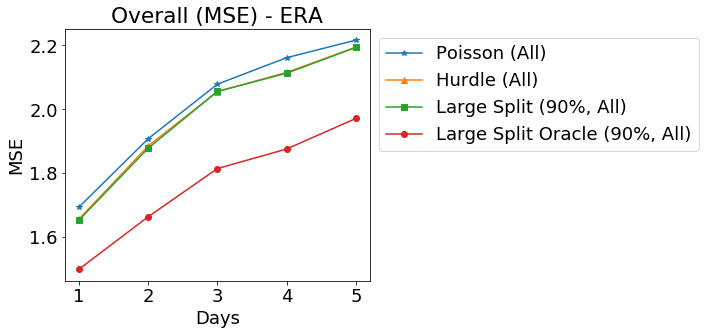

In [549]:
plt.rcParams['figure.figsize'] = [32,5]

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

results_dict = {#'Persistence': persistence['summary_results'],
                #'Poisson (AR)': poisson_ar,
                #'Poisson (Weather)': poisson_weather,
                #'Poisson (Weather + AR)': poisson_weather_ar,
                'Poisson (All)': poisson_weather_ar_mem,
                #'Hurdle (Weather + AR)': hurdle_weather_ar,
                'Hurdle (All)': hurdle_weather_ar_mem,
                'Large Split (90%, All)': large_split_90_true,
                'Large Split Oracle (90%, All)': large_split_90_oracle,
    
}
measurements = [(r'Overall (MSE) - ERA','root_mean_squared_error', False, False),]

alpha = 0.0049727
plot_active_ignition(results_dict, measurements, baseline='Persistence', scale=True, markers=['*', '^', 's', 'o', 'x', 'd', 'v', 'p', 'P', '1'], y_labels = ['MSE', 'MSE SS %'], col_len=1)

In [471]:
%%capture
with open(os.path.join(EXP_DIR, '135764106863738919673641130109397637360.pkl'), 'rb') as fin:
    persistence_aug = pickle.load(fin)

In [506]:
persistence_aug['models'][4][4].afm.model.fit_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               det_diff   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     859.9
Date:                Fri, 09 Nov 2018   Prob (F-statistic):          4.41e-181
Time:                        08:58:06   Log-Likelihood:                -43833.
No. Observations:                9563   AIC:                         8.767e+04
Df Residuals:                    9562   BIC:                         8.768e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
vpd_grad:num_det     9.2359      0.315     29.325      0.000       8.619       9.853
==============================================================================
Omnibus:                     2843.193   Durbin-Watson:                   1.462
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           464029.752
Skew:                          -0.031   Prob(JB):                         0.00
Kurtosis:                      37.126   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""